# **임대주택 단지 내 적정 주차수요 예측 대회_애널리틱스**

In [1]:
PATH = r'C:\Users\Wyatt\wyatt37\data\parking'

In [2]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LassoLars, HuberRegressor, LassoLarsCV

In [4]:
from pycaret.regression import *

In [231]:
age_gender = pd.read_csv(PATH + '\\new_age_gender_info.csv')
train = pd.read_csv(PATH + '\\new_train.csv')
test = pd.read_csv(PATH + '\\new_test.csv')
sub = pd.read_csv(PATH + '\\new_sample_submission.csv')

# DATA UNDERSTANDING

**train.csv - 학습용 데이터**

- 단지코드(key)
- 총세대수
- 임대건물구분
- 지역
- 공급유형
- 전용면적
- 전용면적별세대수
- 공가수: 빈집
- 자격유형: 임차를 할 수 있는 자격 요건
- 임대료보증금
- 임대료
- 도보 10분거리 내 지하철역 수(환승노선 수 반영)
- 도보 10분거리 내 버스정류장 수
- 단지내주차면수
- 등록차량수(target)

**age_gender_info.csv - 지역 임대주택 나이별, 성별 인구 분포**

- 지역
- 10대미만(여자)
- 10대미만(남자)
- 20대(여자)
- 20대(남자)
- 30대(여자)
- 30대(남자)
- 40대(여자)
- 40대(남자)
- 50대(여자)
- 50대(남자)
- 60대(여자)
- 60대(남자)
- 70대(여자)
- 70대(남자)
- 80대(여자)
- 80대(남자)
- 90대(여자)
- 90대(남자)
- 100대(여자)
- 100대(남자)

In [232]:
train.shape, test.shape, age_gender.shape, 

((2952, 15), (1022, 14), (16, 23))

In [233]:
train.describe().T

count        mean         std    min     25%  \
총세대수                          2952.0  886.661247  513.540168  26.00  513.50   
전용면적                          2952.0   44.757215   31.874280  12.62   32.10   
전용면적별세대수                      2952.0  102.747967  132.640159   1.00   14.00   
공가수                           2952.0   12.921070   10.778831   0.00    4.00   
도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741.0    0.176578    0.427408   0.00    0.00   
도보 10분거리 내 버스정류장 수            2948.0    3.695726    2.644665   0.00    2.00   
단지내주차면수                       2952.0  601.668360  396.407072  13.00  279.25   
등록차량수                         2952.0  559.768293  433.375027  13.00  220.00   

                                 50%        75%     max  
총세대수                          779.00  1106.0000  2568.0  
전용면적                           39.93    51.5625   583.4  
전용면적별세대수                       60.00   144.0000  1865.0  
공가수                            11.00    20.0000    55.0  
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0.00     0.0000     3.0  
도보 10분거리 내 버스정류장 수              3.00     4.0000    20.0  
단지내주차면수                       517.00   823.0000  1798.0  
등록차량수                         487.00   770.0000  2550.0

In [234]:
test.describe().T

count        mean         std    min      25%  \
총세대수                          1022.0  862.080235  536.340894  75.00  488.000   
전용면적                          1022.0   43.706311   35.890759   9.96   33.135   
전용면적별세대수                      1022.0  100.414873  125.997855   1.00   14.000   
공가수                           1022.0   15.544031   11.070140   0.00    6.000   
도보 10분거리 내 지하철역 수(환승노선 수 반영)   980.0    0.136735    0.435500   0.00    0.000   
도보 10분거리 내 버스정류장 수            1022.0    4.626223    5.414568   1.00    2.000   
단지내주차면수                       1022.0  548.771037  342.636703  29.00  286.000   

                                 50%     75%     max  
총세대수                          745.00  1161.0  2572.0  
전용면적                           39.72    47.4   583.4  
전용면적별세대수                       60.00   140.0  1341.0  
공가수                            15.00    23.0    45.0  
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0.00     0.0     2.0  
도보 10분거리 내 버스정류장 수              3.00     5.0    50.0  
단지내주차면수                       458.00   711.0  1696.0

- train set과 test set 의 평균과 편차가 큰 차이가 없습니다.

## age_gender_info

In [235]:
ag = age_gender.set_index('지역')

In [236]:
ag.loc['전체 평균'] = ag.mean()
ag.loc['광역시 평균'] = ag.loc[(ag.index.str.contains('시')) & (~ag.index.str.contains('세종'))].mean()
ag.loc['도 평균'] = ag.loc[ag.index.str.contains('도')].mean()

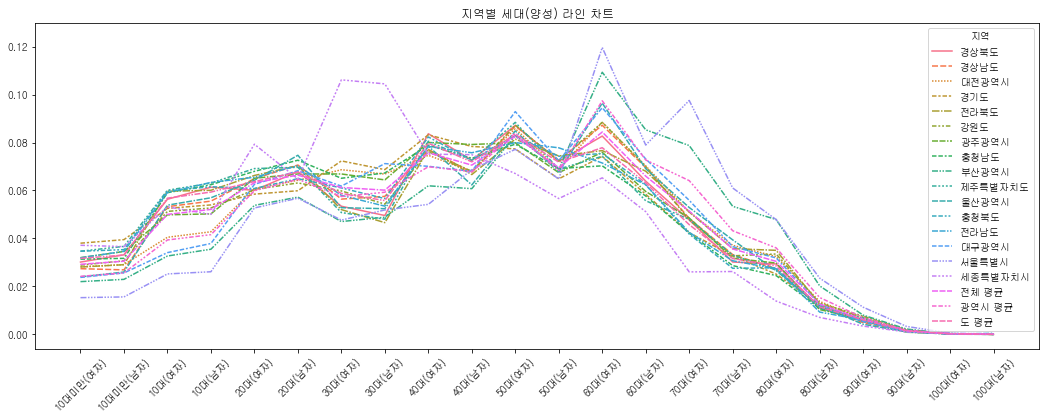

In [237]:
fig = plt.figure(figsize = (18, 6))
sns.lineplot(data=ag.T, )
plt.title('지역별 세대(양성) 라인 차트')
plt.xticks(rotation=45)
plt.ylim(top=0.13)
plt.show()

- 비교적 정규 분포의 모양을 띄고 있습니다.
- 같은 나이대임에도 성별에 따라 편차가 존재합니다. 대체로 남성보다는 여성이 높은 비율을 보이고 있습니다.
- 서울특별시는 60대 여성, 70대 여성에서 피크를 보이고 있습니다.
- 부산광역시 또한 서울과 비슷한 패턴을 보입니다.
- 세종특별자치시는 다른 시도와는 다르게 30대에서 매우 높은 비중을 보입니다.

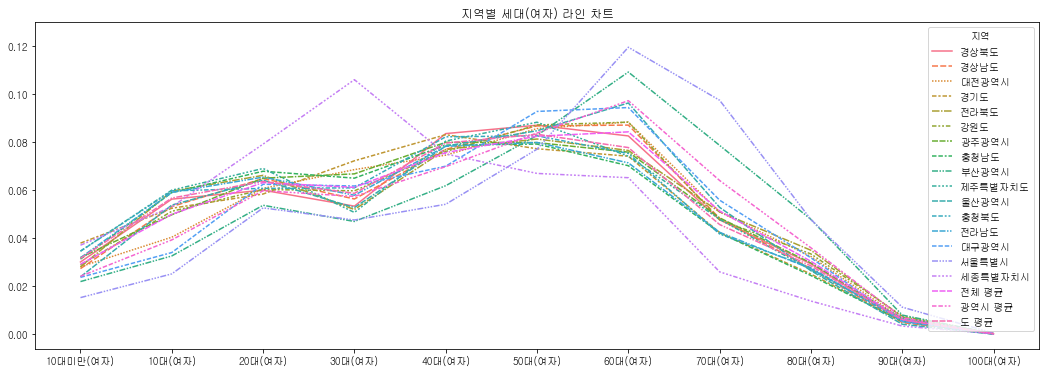

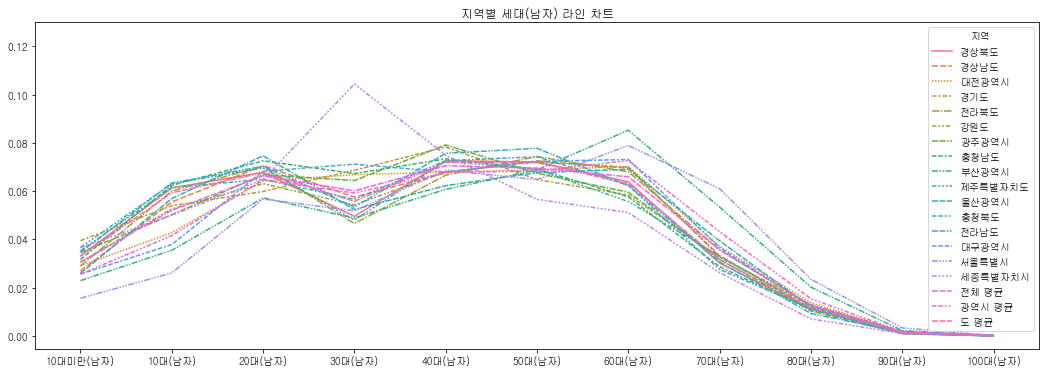

In [238]:
fig = plt.figure(figsize = (18, 6))
sns.lineplot(data=ag.loc[:, ag.columns.str.contains('여자')].T)
plt.title('지역별 세대(여자) 라인 차트')
plt.ylim(top=0.13)
plt.show()

fig = plt.figure(figsize = (18, 6))
sns.lineplot(data=ag.loc[:, ag.columns.str.contains('남자')].T)
plt.title('지역별 세대(남자) 라인 차트')
plt.ylim(top=0.13)
plt.show()

- 성별을 기준으로 따로 플롯을 그려보았을 때, 절대적인 비율의 차이는 있지만, 패턴은 똑같습니다.

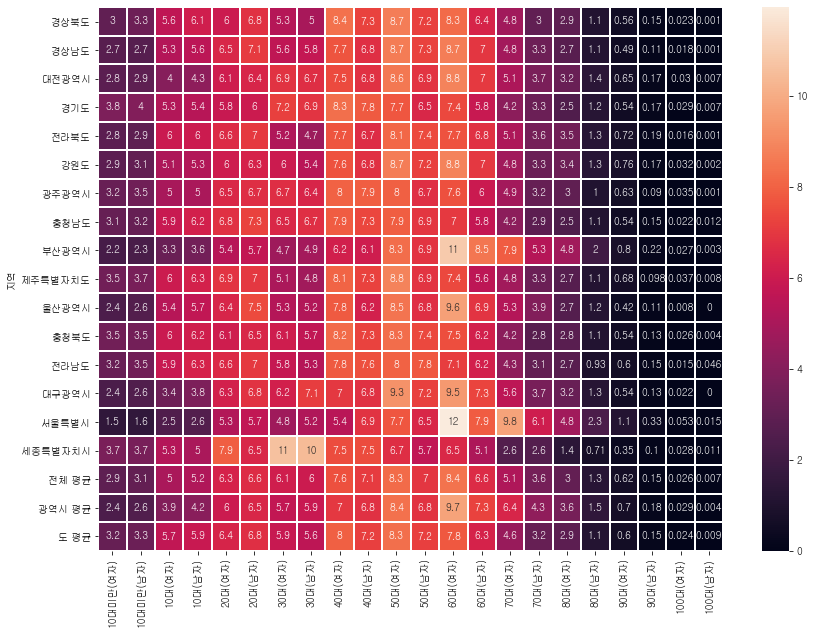

In [239]:
plt.figure(figsize=(14, 10))
sns.heatmap((ag*100).round(3),
           annot=True, linewidths=0.01,)

plt.show()

- 인구가 많은 특별시, 광역시에서 60~70대의 비중이 높은 것을 알 수 있습니다. (서울, 부산, 울산, 대구 등)
- 앞서 보았듯이 세종은 청년층 20~30대의 비중이 매우 높게 형성되어 있습니다.
- 광역시(세종 제외)와 도단위 지역구의 평균을 비교했을 때, 10대와 40대, 60~70대에서 차이가 두드러집니다.

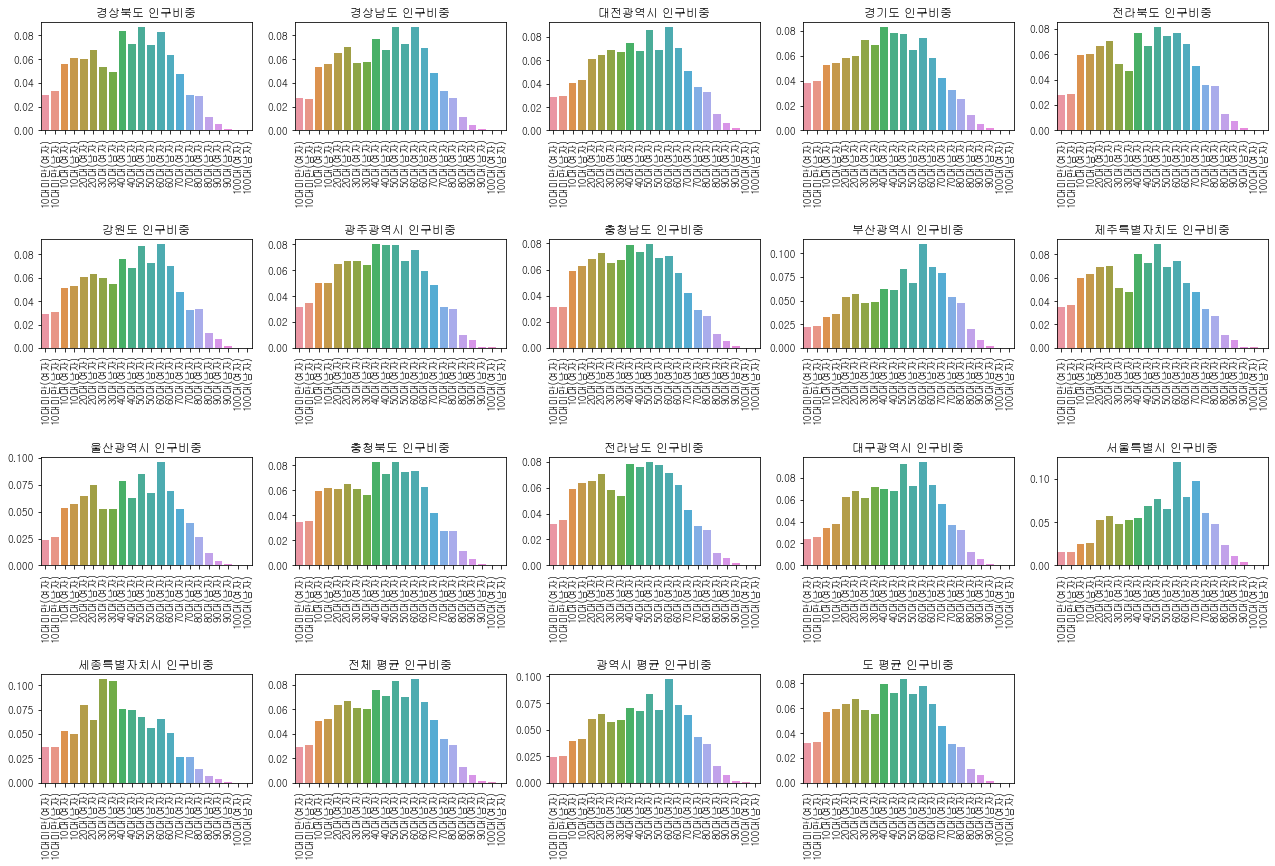

In [240]:
fig = plt.figure(figsize=(22, 18))
plt.xticks(rotation=90)
for i, n in enumerate(list(ag.index)):
    plt.subplot(5, 5, i+1)
    plt.subplots_adjust(hspace=1.0)
    plt.title("{} 인구비중".format(n))
    sns.barplot(data=ag.loc[ag.index == n])
    plt.xticks(rotation=90)

- 각 행정구역별로 바플롯을 그려보았을 때, 앞서 살펴 본 특징들을 확인할 수 있습니다.
- 세종을 제외하고는 크게 두 패턴으로 나뉘는 것을 알 수 있습니다.

## train/test

먼저 기본적인 컬럼별 밸류 체크부터 하겠습니다.

### Column_Values_Check

In [241]:
def check_train_test_column_values(train, test, column):
    # 함수 정의: 두 데이터 테이블과 특정 컬럼을 집어 넣으면 value를 비교하여 출력하는 함수
    print("{} Column에 대한 train_test_values_check 입니다=======================".format(column))
    # Train/Test set의 입력 칼럼의 value를 set으로 받아줍니다.
    train_colset = set(train[column])
    test_colset  = set(test[column])

    # Train/Test-set 고유한 value의 개수를 구함.
    print(f"Train-set에 있는 고유한 value 개수 : {len(train_colset)}")
    print(f"Test-set에 있는 고유한 value 개수 : {len(test_colset)}")

    # Train/Test-set 모두에 포함되어있는 value를 구함.
    print('='* 80)
    common_colset = train_colset.intersection(test_colset)
    print(f"Train/Test-set에 공통으로 포함되어 있는 value 개수 : {len(common_colset)}")
    if len(common_colset) > 100: # value가 너무 많으면 어차피 보기 힘드므로 출력을 pass 합니다
        pass
    else:
        try: # int나 float은 sorted가 먹지 않기 때문에 try except로 넣어줍니다.
            print(f"Train/Test-set에 공통으로 포함되어 있는 value : {sorted(common_colset)}")
        except:
            print(f"Train/Test-set에 공통으로 포함되어 있는 value : {(common_colset)}")

    # Train-set에만 있는 value를 구함.
    print('='* 80)
    train_only_colset = train_colset.difference(test_colset)
    print(f"Train-set에만 있는 value는 총 {len(train_only_colset)} 개 입니다.")
    if len(train_only_colset) > 100:
        pass
    else:
        try:
            print(f"Train-set에만 있는 value는 : {sorted(train_only_colset)}")
        except:
            print(f"Train-set에만 있는 value는 : {(train_only_colset)}")

    # Test-set에만 있는 value를 구함.
    print('='* 80)
    test_only_colset = test_colset.difference(train_colset)
    print(f"Test-set에만 있는 value는 총 {len(test_only_colset)} 개 입니다.")
    if len(test_only_colset) > 100:
        pass
    else:
        try:
            print(f"Test-set에만 있는 value는 : {sorted(test_only_colset)}")
        except:
            print(f"Test-set에만 있는 value는 : {(test_only_colset)}")
    print(" ")

In [242]:
obj_cols = []
for col in train.columns:
    if train[col].dtypes == 'object':
        obj_cols.append(col)

In [243]:
for col in obj_cols:
    check_train_test_column_values(train, test, col)

단지코드 Column에 대한 train_test_values_check 입니다=======================
Train-set에 있는 고유한 value 개수 : 423
Test-set에 있는 고유한 value 개수 : 150
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 0
Train/Test-set에 공통으로 포함되어 있는 value : []
Train-set에만 있는 value는 총 423 개 입니다.
Test-set에만 있는 value는 총 150 개 입니다.
 
임대건물구분 Column에 대한 train_test_values_check 입니다=======================
Train-set에 있는 고유한 value 개수 : 2
Test-set에 있는 고유한 value 개수 : 2
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 2
Train/Test-set에 공통으로 포함되어 있는 value : ['상가', '아파트']
Train-set에만 있는 value는 총 0 개 입니다.
Train-set에만 있는 value는 : []
Test-set에만 있는 value는 총 0 개 입니다.
Test-set에만 있는 value는 : []
 
지역 Column에 대한 train_test_values_check 입니다=======================
Train-set에 있는 고유한 value 개수 : 16
Test-set에 있는 고유한 value 개수 : 15
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 15
Train/Test-set에 공통으로 포함되어 있는 value : ['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도']
Train-set에만 있는 value는 총 1 개 입니다.
T

- train set과 test set 간의 컬럼별 밸류 차이가 다소 존재합니다.

train 데이터는 2개의 테이블이 합쳐진 것으로 판단 됩니다.

- 아파트 단지 타입별로 나뉘어진 테이블과
- 아파트 단지의 정보가 담긴 테이블입니다.
- 또한 아파트 단지에 대한 정보를 아파트 유형과 상가 유형으로 나눌 수 있습니다.

### NA_Values_Check

결측치부터 살펴보겠습니다.

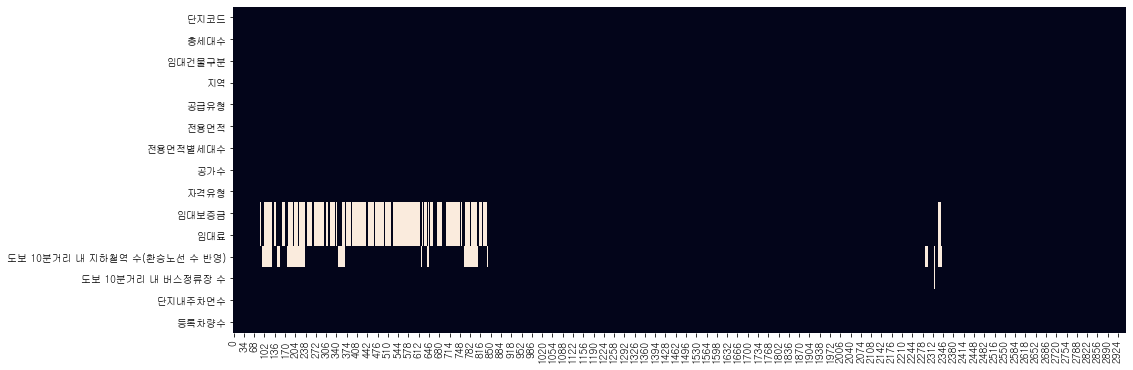

In [244]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.isnull().T, cbar=False)
plt.show()

In [245]:
train.isnull().sum().to_frame()

0
단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            0
임대보증금                         569
임대료                           569
도보 10분거리 내 지하철역 수(환승노선 수 반영)  211
도보 10분거리 내 버스정류장 수              4
단지내주차면수                         0
등록차량수                           0

- 임대보증금, 임대료, 지하철역, 버스정류장 에서 결측치가 있습니다.
- 임대보증금, 임대료에서의 결측치는 등장하는 row가 동일해 보입니다.

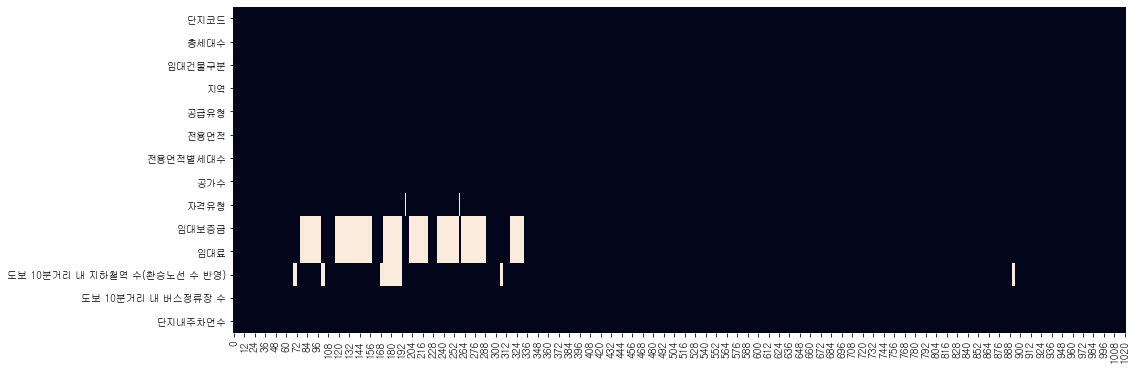

In [246]:
plt.figure(figsize=(16, 6))
sns.heatmap(test.isnull().T, cbar=False)
plt.show()

In [247]:
test.isnull().sum().to_frame()

0
단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            2
임대보증금                         180
임대료                           180
도보 10분거리 내 지하철역 수(환승노선 수 반영)   42
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0

- test set에서는 자격유형에서 결측치가 조금 보입니다.
- 그리고 지하철역에서 결측치가 많이 보입니다.

# PREPROCESSING

In [248]:
# 컬럼명이 너무 긴 지하철과 버스만 바꿔주겠습니다.
train.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)
test.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)

## FILLNA

### Subway

In [249]:
# train set에 지하철 정보가 없는 경남, 충남은 0으로 보간
train.loc[(train['지역'].isin(['경상남도', '충청남도'])) & (train['지하철'].isnull()), '지하철'] = 0

In [250]:
# LH청약센터에서 찾은 주소로 확인한 대전의 8개 단지는 지하철이 없음
# 0으로 채워줍시다.

(train.loc[(train['지역'] == '대전광역시') & (train['지하철'].isnull()) , '지하철']) = 0

In [251]:
# test set에 지하철 정보가 없는 충남은 0으로 보간
test.loc[(test['지역'].isin(['충청남도'])) & (test['지하철'].isnull()), '지하철'] = 0

In [252]:
# LH청약센터에서 찾은 주소로 확인한 대전의 2개 단지는 지하철이 없음
# 0으로 채워줍시다.

(test.loc[(test['지역'] == '대전광역시') & (test['지하철'].isnull()), '지하철']) = 0

### Bus

In [253]:
# 버스정류장 결측치는 train set에 1개 단지에 존재
# 해당 단지는 양산신도시LH아파트 5단지
# 동일 단지인 C2431에서 2로 되어 있음.

train.loc[train['버스'].isnull(), '버스'] = 2

### Rent

In [254]:
# test set 에 임대보증금과 임대료가 결측치인 1개 단지 존재
# 해당 단지는 대전둔산1단지주공아파트
# 공고문에 의거, 임대보증금과 임대료 아래와 같이 보간

test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull()), '임대보증금'] = [5787000, 5787000, 11574000]
test.loc[(test['임대건물구분'] != '상가') & (test['임대료'].isnull()), '임대료'] = [79980, 79980, 159960]

### Qualification

In [255]:
# C2411 아파트의 자격유형은 전부 A로 되어 있음.
# 동일하게 A로 보간

test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

In [256]:
# C2253 아파트의 자격유형은 전부 C로 되어 있음.
# 동일하게 C로 보간

test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

## REPLACING

https://www.dacon.io/competitions/official/235745/talkboard/403708?page=1&dtype=recent

### ※ 동일한 단지에 코드가 2개로 부여된 단지 코드 (3쌍)
- : ['C2085', 'C1397'], ['C2431', 'C1649'], ['C1036', 'C2675'] 
 - C2675 단지는 테스트셋, 나머지는 트레인셋 입니다.

In [257]:
# ['C2085', 'C1397'] 을 C1397로 합병
train.loc[train['단지코드'] == 'C2085', '단지코드'] = 'C1397'
train.loc[train['단지코드'] == 'C1397', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1397'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)
train.loc[train['단지코드'] == 'C1397', '공가수'] = 9

In [77]:
# ['C2431', 'C1649'] 을 C1649로 합병
train.loc[train['단지코드'] == 'C2431', '단지코드'] = 'C1649'
train.loc[train['단지코드'] == 'C1649', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1649'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)
train.loc[train['단지코드'] == 'C1649', '공가수'] = 31
train.loc[train['단지코드'] == 'C1649', '등록차량수'] = 1214

In [78]:
# ['C1036', 'C2675'] 은 train과 test로 나누어져 있으니 drop
train.drop(train.loc[train['단지코드'] == 'C1036'].index, axis=0, inplace=True)
test.drop(test.loc[test['단지코드'] == 'C2675'].index, axis=0, inplace=True)

### ※ 차이가 94~452세대인 10개 단지(크기순)
- : ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804’]

In [79]:
# 경북혁신도시천년나무3단지
test.loc[test['단지코드'] == 'C2497', '전용면적별세대수'] = [114, 60, 275, 39]

# 충무공동혁신도시LH아파트5단지
train.loc[train['단지코드'] == 'C2405', '전용면적별세대수'] = [100, 100, 400]
# 경북혁신LH천년나무2단지
train.loc[train['단지코드'] == 'C1740', '전용면적별세대수'] = [305, 126, 184, 168]
# LH강남아이파크
train.loc[train['단지코드'] == 'C1024', '전용면적별세대수'] = [195, 60, 15, 154, 99, 48, 42, 53, 29, 23]
# 서울서초A4BL
train.loc[train['단지코드'] == 'C1344', '전용면적별세대수'] = [106, 96, 41, 39, 42, 100]
# 진천군 연미로 131 천년나무7단지
train.loc[train['단지코드'] == 'C1490', '전용면적별세대수'] = [105, 84, 472, 88]
# 나주빛가람LH3단지
train.loc[train['단지코드'] == 'C2620', '전용면적별세대수'] = [60, 227, 316, 160, 266]
# 남양주별내A1-3블록
train.loc[train['단지코드'] == 'C1804', '전용면적별세대수'] = [76, 82, 279, 28]

In [80]:
# 남양주별내A1-3블록
train = train.append({'단지코드': 'C1804',
                      '총세대수': 478,
                      '임대건물구분': '아파트',
                      '지역': '경기도',
                      '공급유형': '공공임대(10년)',
                      '전용면적': 75.78,
                      '전용면적별세대수': 13,
                      '공가수': 3.0,
                      '자격유형': 'A',
                      '임대보증금': 78957000,
                      '임대료': 530130,
                      '지하철': 0.0,
                      '버스': 3.0,
                      '단지내주차면수': 629.0,
                      '등록차량수': 951.0}, ignore_index=True)
# 대전대신2구역2단지
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.99,
                      '전용면적별세대수': 72,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 225013300,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.95,
                      '전용면적별세대수': 66,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 226278000,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.99,
                      '전용면적별세대수': 92,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 230417000,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
# 속초청초아파트
train = train.append({'단지코드': 'C1206',
                      '총세대수': 755,
                      '임대건물구분': '아파트',
                      '지역': '강원도',
                      '공급유형': '영구임대',
                      '전용면적': 41.85,
                      '전용면적별세대수': 177,
                      '공가수': 1.0,
                      '자격유형': 'C',
                      '지하철': 0.0,
                      '버스': 4.0,
                      '단지내주차면수': 88.0,
                      '등록차량수': 90.0}, ignore_index=True)
train = train.append({'단지코드': 'C1206',
                      '총세대수': 755,
                      '임대건물구분': '아파트',
                      '지역': '강원도',
                      '공급유형': '영구임대',
                      '전용면적': 51.66,
                      '전용면적별세대수': 90,
                      '공가수': 1.0,
                      '자격유형': 'C',
                      '지하철': 0.0,
                      '버스': 4.0,
                      '단지내주차면수': 88.0,
                      '등록차량수': 90.0}, ignore_index=True)

In [81]:
# train의 C1024는 다른 단지와 다르게 총세대수보다 전용면적별세대수합이 더 큽니다.
train.loc[train['단지코드'] == 'C1024', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1024'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)

### ※ 실수가 발생한 단지 코드 (9개 단지)
- : ['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
 - C2335, C1327 단지는 테스트셋, 나머지는 트레인셋 입니다.

In [83]:
# # 노이즈로 판결났으므로 부득이하게 레코드 드랍
train.drop(train.loc[train['단지코드'].isin(['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])].index, axis=0, inplace=True)
test.drop(test.loc[test['단지코드'].isin(['C2335', 'C1327'])].index, axis=0, inplace=True)

### UnitCount

In [84]:
train = pd.merge(train.loc[:, ~train.columns.isin(['총세대수'])],
                 train.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수':'총세대수'}, axis=1),
                 how='left', on='단지코드')

In [85]:
test = pd.merge(test.loc[:, ~test.columns.isin(['총세대수'])],
                test.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수':'총세대수'}, axis=1),
                how='left', on='단지코드')

### Qualification

'D' 는 상가에서 보여지는 자격유형입니다. 그러나 train, test 셋에 각각 존재합니다.

In [86]:
# train의 C1350의 D는 최빈값 A로 넣겠습니다.
train.loc[(train['자격유형'] == 'D') & (train['임대건물구분'] == '아파트'), '자격유형'] = (
    train.loc[(train['단지코드'] == 'C1350') & (~train['임대료'].isnull()), '자격유형'].mode()[0]
)

In [87]:
# test의 C1006의 D값은 최빈값인 C로 대체하겠습니다.
test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'] = (
    test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'].mode()[0]
)

### Shops

용이한 전처리를 위해 상가는 따로 뗴어두고 나중에 합칩니다.

In [88]:
train_shops = train.loc[train['임대건물구분'] == '상가'].groupby(['단지코드']).sum()[['전용면적별세대수', '전용면적']]
test_shops = test.loc[test['임대건물구분'] == '상가'].groupby(['단지코드']).sum()[['전용면적별세대수', '전용면적']]

In [89]:
train = train.loc[train['임대건물구분'] == '아파트']
test = test.loc[test['임대건물구분'] == '아파트']

### Deposit / Rent Preprocessing

임대료가 없는 단지를 비교하기 위해서 임대료를 만들어주겠습니다.

In [90]:
# '-' 값을 0으로 만들어줍니다.
train.loc[train['임대보증금'] == '-', '임대보증금'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

train.loc[train['임대료'] == '-', '임대료'] = 0
test.loc[test['임대료'] == '-', '임대료'] = 0

In [91]:
# nan 값 때문에 object로 되어 있습니다. 일단 0으로 채워 줍니다.
train['임대보증금'] = train['임대보증금'].fillna(0)
test['임대보증금'] = test['임대보증금'].fillna(0)

train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [92]:
# 계산을 위해서 int로 바꿔줍니다.
train['임대보증금'] = train['임대보증금'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

train['임대료'] = train['임대료'].astype(int)
test['임대료'] = test['임대료'].astype(int)

In [93]:
# 면적당으로 보증금과 임대료를 산출해서 역으로 채워넣겠습니다.
train['면적당보증금'] = train['임대보증금'] / train['전용면적']
train['면적당임대료'] = train['임대료'] / train['전용면적']

test['면적당보증금'] = test['임대보증금'] / test['전용면적']
test['면적당임대료'] = test['임대료'] / test['전용면적']

In [94]:
# 0 값을 다시 NULL 값으로 바꿉니다.
train.loc[(train['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
train.loc[(train['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

test.loc[(test['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
test.loc[(test['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

train에서 공공분양, 장기전세가 아니면서 보증금과 임대료가 비어있는 곳은 C1350, C1786, C2186, C1326, C1206 입니다.

In [95]:
# C1350은 공공분양이기 때문에 임대료가 없고 보증금이 매우 큽니다.
# 이 경우는 비슷한 공급유형의 면적당보증금을 가져오겠습니다.
# 임대료는 추후 작업하겠습니다.

# 같은 유형의 공공분양 단지의 면적당 보증금의 평균으로 채워줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '공공분양') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금']
)

In [96]:
# C1786 은 행복주택, K 유형의 아파트입니다.
# 동일한 공급유형, 자격유형의 값을 가져오겠습니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당보증금'].mean()
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금']
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대료'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료']
)

In [97]:
# C2186 단지는 같은 단지에 동일한 공급유형, 동일한 자격유형의 값이 있습니다.
# 해당 값으로 넣어주겠습니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대료'].isnull()), '면적당임대료'].mean()
)
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '임대료'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '면적당임대료']
)
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '면적당보증금']
)

In [98]:
# C1326 단지는 동일 지역에 H국민임대 단지가 없습니다. 전국적으로 4000~6500원 선이니 평균으로 넣어주겠습니다.
train.loc[train['단지코드'] == 'C1326', '면적당보증금'] = (
    train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H'), '면적당보증금'].mean()
)
train.loc[train['단지코드'] == 'C1326', '면적당임대료'] = (
    train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[train['단지코드'] == 'C1326', '임대보증금'] = (
    train.loc[train['단지코드'] == 'C1326', '면적당보증금']
    * train.loc[train['단지코드'] == 'C1326', '전용면적']
)
train.loc[train['단지코드'] == 'C1326', '임대료'] = (
    train.loc[train['단지코드'] == 'C1326', '면적당임대료']
    * train.loc[train['단지코드'] == 'C1326', '전용면적']
)

In [99]:
# C1206 단지는 동일 단지로 채워줍니다.
train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '영구임대') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)
train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '영구임대') & (~train['임대료'].isnull()), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '면적당보증금']
)
train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '임대료'] = (
    train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '면적당임대료']
)

test의 보증금과 임대료가 비어 있는 곳은 C1267, C2152 입니다.

In [100]:
# C1267 단지는 train의 동일공급유형, 동일자격유형, 거기에 경기도를 뺀 지역의 평균을 넣겠습니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'L') & (train['지역'] != '경기도'), '면적당보증금'].mean()
)
test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'L') & (train['지역'] != '경기도'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '임대보증금'] = (
    test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '전용면적']
    * test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '면적당보증금']
)
test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '임대료'] = (
    test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '전용면적']
    * test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '면적당임대료']
)

In [101]:
# C2152 단지는 train의 동일 공급유형, 자격유형의 전국 평균 값으로 넣겠습니다.
test.loc[test['단지코드'] == 'C2152', '면적당보증금'] = (
    train.loc[(train['공급유형'] == '영구임대') & (train['자격유형'] == 'C'), '면적당보증금'].mean()
)
test.loc[test['단지코드'] == 'C2152', '면적당임대료'] = (
    train.loc[(train['공급유형'] == '영구임대') & (train['자격유형'] == 'C'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
test.loc[test['단지코드'] == 'C2152', '임대보증금'] = (
    test.loc[test['단지코드'] == 'C2152', '전용면적']
    * test.loc[test['단지코드'] == 'C2152', '면적당보증금']
)
test.loc[test['단지코드'] == 'C2152', '임대료'] = (
    test.loc[test['단지코드'] == 'C2152', '전용면적']
    * test.loc[test['단지코드'] == 'C2152', '면적당임대료']
)

장기전세와 공공분양 ['C1397', 'C1039', 'C1350', 'C2470', 'C1206']

In [102]:
train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [103]:
train['면적당임대료'] = train['면적당임대료'].fillna(0)
test['면적당임대료'] = test['면적당임대료'].fillna(0)

In [104]:
train['환산보증금'] = train['임대료'] * 354 + train['임대보증금']
test['환산보증금'] = test['임대료'] * 354 + test['임대보증금']

In [105]:
train['면적당환산보증금'] = train['환산보증금'] / train['전용면적']
test['면적당환산보증금'] = test['환산보증금'] / test['전용면적']

In [106]:
train.describe().T

count          mean           std           min           25%  \
전용면적      2333.0  4.441075e+01  1.295527e+01  1.602000e+01  3.664000e+01   
전용면적별세대수  2333.0  1.280039e+02  1.374597e+02  2.000000e+00  3.900000e+01   
공가수       2333.0  1.420703e+01  1.041014e+01  0.000000e+00  7.000000e+00   
임대보증금     2333.0  2.750465e+07  2.567513e+07  3.056000e+06  1.441800e+07   
임대료       2333.0  1.906883e+05  1.274788e+05  0.000000e+00  1.101100e+05   
지하철       2333.0  1.358766e-01  4.015019e-01  0.000000e+00  0.000000e+00   
버스        2333.0  3.715388e+00  2.742448e+00  0.000000e+00  2.000000e+00   
단지내주차면수   2333.0  6.770403e+02  3.936255e+02  1.300000e+01  3.840000e+02   
등록차량수     2333.0  6.526811e+02  4.310643e+02  1.300000e+01  3.490000e+02   
총세대수      2333.0  8.033836e+02  4.354635e+02  2.600000e+01  4.930000e+02   
면적당보증금    2333.0  6.066759e+05  4.661500e+05  1.158893e+05  3.543673e+05   
면적당임대료    2333.0  4.153592e+03  1.824358e+03  0.000000e+00  2.817910e+03   
환산보증금     2333.0  9.500832e+07  5.837917e+07  2.691560e+07  5.590048e+07   
면적당환산보증금  2333.0  2.077048e+06  8.247743e+05  7.315109e+05  1.420115e+06   

                   50%           75%           max  
전용면적      4.657000e+01  5.178000e+01  8.499000e+01  
전용면적별세대수  8.900000e+01  1.680000e+02  1.865000e+03  
공가수       1.300000e+01  2.100000e+01  5.500000e+01  
임대보증금     2.063800e+07  3.244300e+07  2.575233e+08  
임대료       1.585400e+05  2.322000e+05  1.058030e+06  
지하철       0.000000e+00  0.000000e+00  3.000000e+00  
버스        3.000000e+00  4.000000e+00  2.000000e+01  
단지내주차면수   6.240000e+02  8.820000e+02  1.798000e+03  
등록차량수     5.660000e+02  8.320000e+02  2.550000e+03  
총세대수      7.490000e+02  1.013000e+03  2.568000e+03  
면적당보증금    4.755141e+05  6.880174e+05  3.783236e+06  
면적당임대료    3.856495e+03  5.251783e+03  1.284751e+04  
환산보증금     7.799526e+07  1.126182e+08  4.918516e+08  
면적당환산보증금  1.922820e+06  2.588674e+06  5.873442e+06

# INVESTIGATION

- 수사에 돌입하겠습니다.
- 정황파악(BA&DA) -> 가설설정 -> 증거수집(EDA) -> 추가 증거수집(DEEP EDA) -> 증거 조합 -> 인사이트 체포

아파트 단지 내 필요한 주차대수는 **①법정주차대수 ②장래주차수요 중 큰 값에 따라 결정**하게되어 있어, **정확한 ②장래주차수요의 산정을 필요**로 합니다.
현재 ②장래주차수요는 **‘주차원단위’**와 **‘건축연면적’**을 기초로하여 산출되고 있으며, **‘주차원단위’는 신규 건축예정 부지 인근의 유사 단지를 피크 시간대 방문하여 주차된 차량대수를 세는 방법으로 조사**하고 있습니다.
이 경우 인력조사로 인한 오차발생, 현장조사 시점과 실제 건축시점과의 시간차 등의 문제로 과대 또는 과소 산정의 가능성을 배제할 수 없습니다.

위 정보에서 알 수 있는 것은 무조건 최소한 법정주차대수보다는 높게 선정해야 한다는 것이다.
- 장래주차수요가 적은 경우 -> 법정주차대수로 결정
- 장래주차수요가 큰 경우 -> 법정주차대수보다 큰 장래주차수요로 결정
- 어떤 경우에도 최소한 법정주차대수보다 큼

법정주차대수는 1995년 즈음에 만들어져서 최근에는 많이 변화했습니다. 그만큼 옛날 아파트와 최신 아파트의 편차가 클 수 밖에 없습니다.
- 대략 서울시의 85타입 100세대는 113대의 법정주차대수로 산정합니다.
- 도시에서 입지가 좋은 아파트의 경우는 오래된 경우에도 수요가 있을 것입니다.
- 그러나 인구가 적은 지역에서는 소득이 괜찮다면 좋은 집에 살 수 있습니다.

아파트의 건축연도를 알 수 있으면 좋겠습니다.

또한 아파트의 입지를 알 수 있으면 좋겠습니다.

In [107]:
train['건축연면적'] = train['전용면적'] * train['전용면적별세대수']
test['건축연면적'] = test['전용면적'] * test['전용면적별세대수']

In [108]:
train['세대수X환산보증금'] = train['전용면적별세대수'] * train['환산보증금']
test['세대수X환산보증금'] = test['전용면적별세대수'] * test['환산보증금']

In [109]:
train_apart = train[['단지코드', '임대건물구분', '공급유형', '전용면적',
                     '전용면적별세대수', '자격유형', '임대보증금', '임대료']].loc[train['임대건물구분'] == '아파트']

train_shop = train[['단지코드', '임대건물구분', '공급유형', '전용면적',
                    '전용면적별세대수', '자격유형']].loc[train['임대건물구분'] == '상가']

train_danji = train[['단지코드', '총세대수', '지역', '공가수', '지하철',
                     '버스', '단지내주차면수', '등록차량수']].drop_duplicates().reset_index(drop=True)

test_apart = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형',
                   '임대보증금', '임대료']].loc[test['임대건물구분'] == '아파트']

test_shop = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수',
                  '자격유형']].loc[test['임대건물구분'] == '상가']

test_danji = test[['단지코드', '총세대수', '지역', '공가수', '지하철',
                   '버스', '단지내주차면수']].drop_duplicates().reset_index(drop=True)

### 산점도(x=주차면수, y=등록차량수)

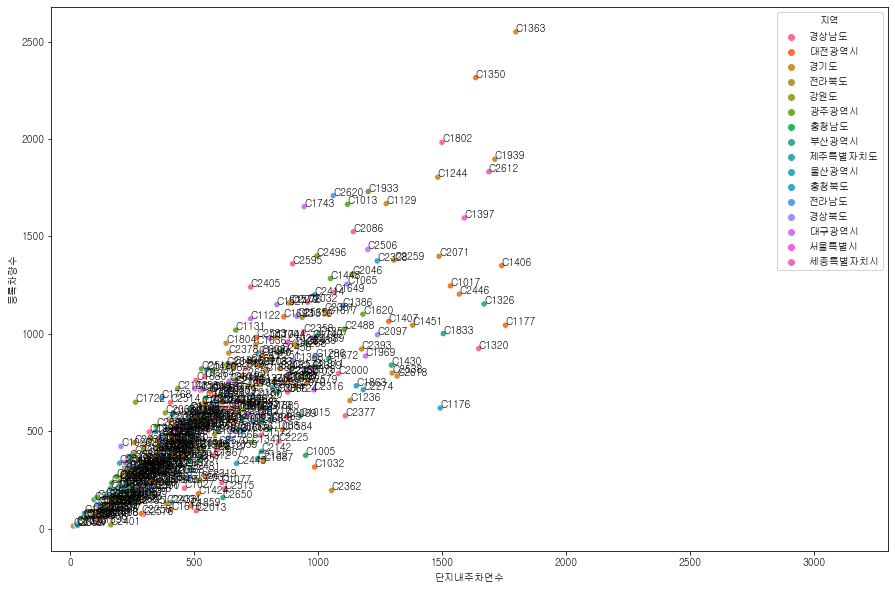

In [110]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='단지내주차면수', y='등록차량수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['단지내주차면수'][i], train_danji['등록차량수'][i]))
plt.xlim(right=3300)
plt.show()

In [124]:
train_danji.loc[train_danji['단지코드'].isin(['C2362', 'C2013', 'C2576', 'C1859', 'C2401']),
               ['단지코드', '단지내주차면수', '등록차량수', '지역']]

단지코드  단지내주차면수  등록차량수     지역
13   C2576    296.0   73.0   경상남도
18   C2013    509.0   91.0   경상남도
29   C1859    487.0  116.0  대전광역시
69   C2401    164.0   19.0    강원도
388  C2362   1055.0  196.0    경기도

- 주차면수에 비해 등록차량수가 너무 적은 단지들이 있습니다. 대표적으로 C2362입니다.

### 레그플롯_지역별(x=주차면수, y=등록차량수)

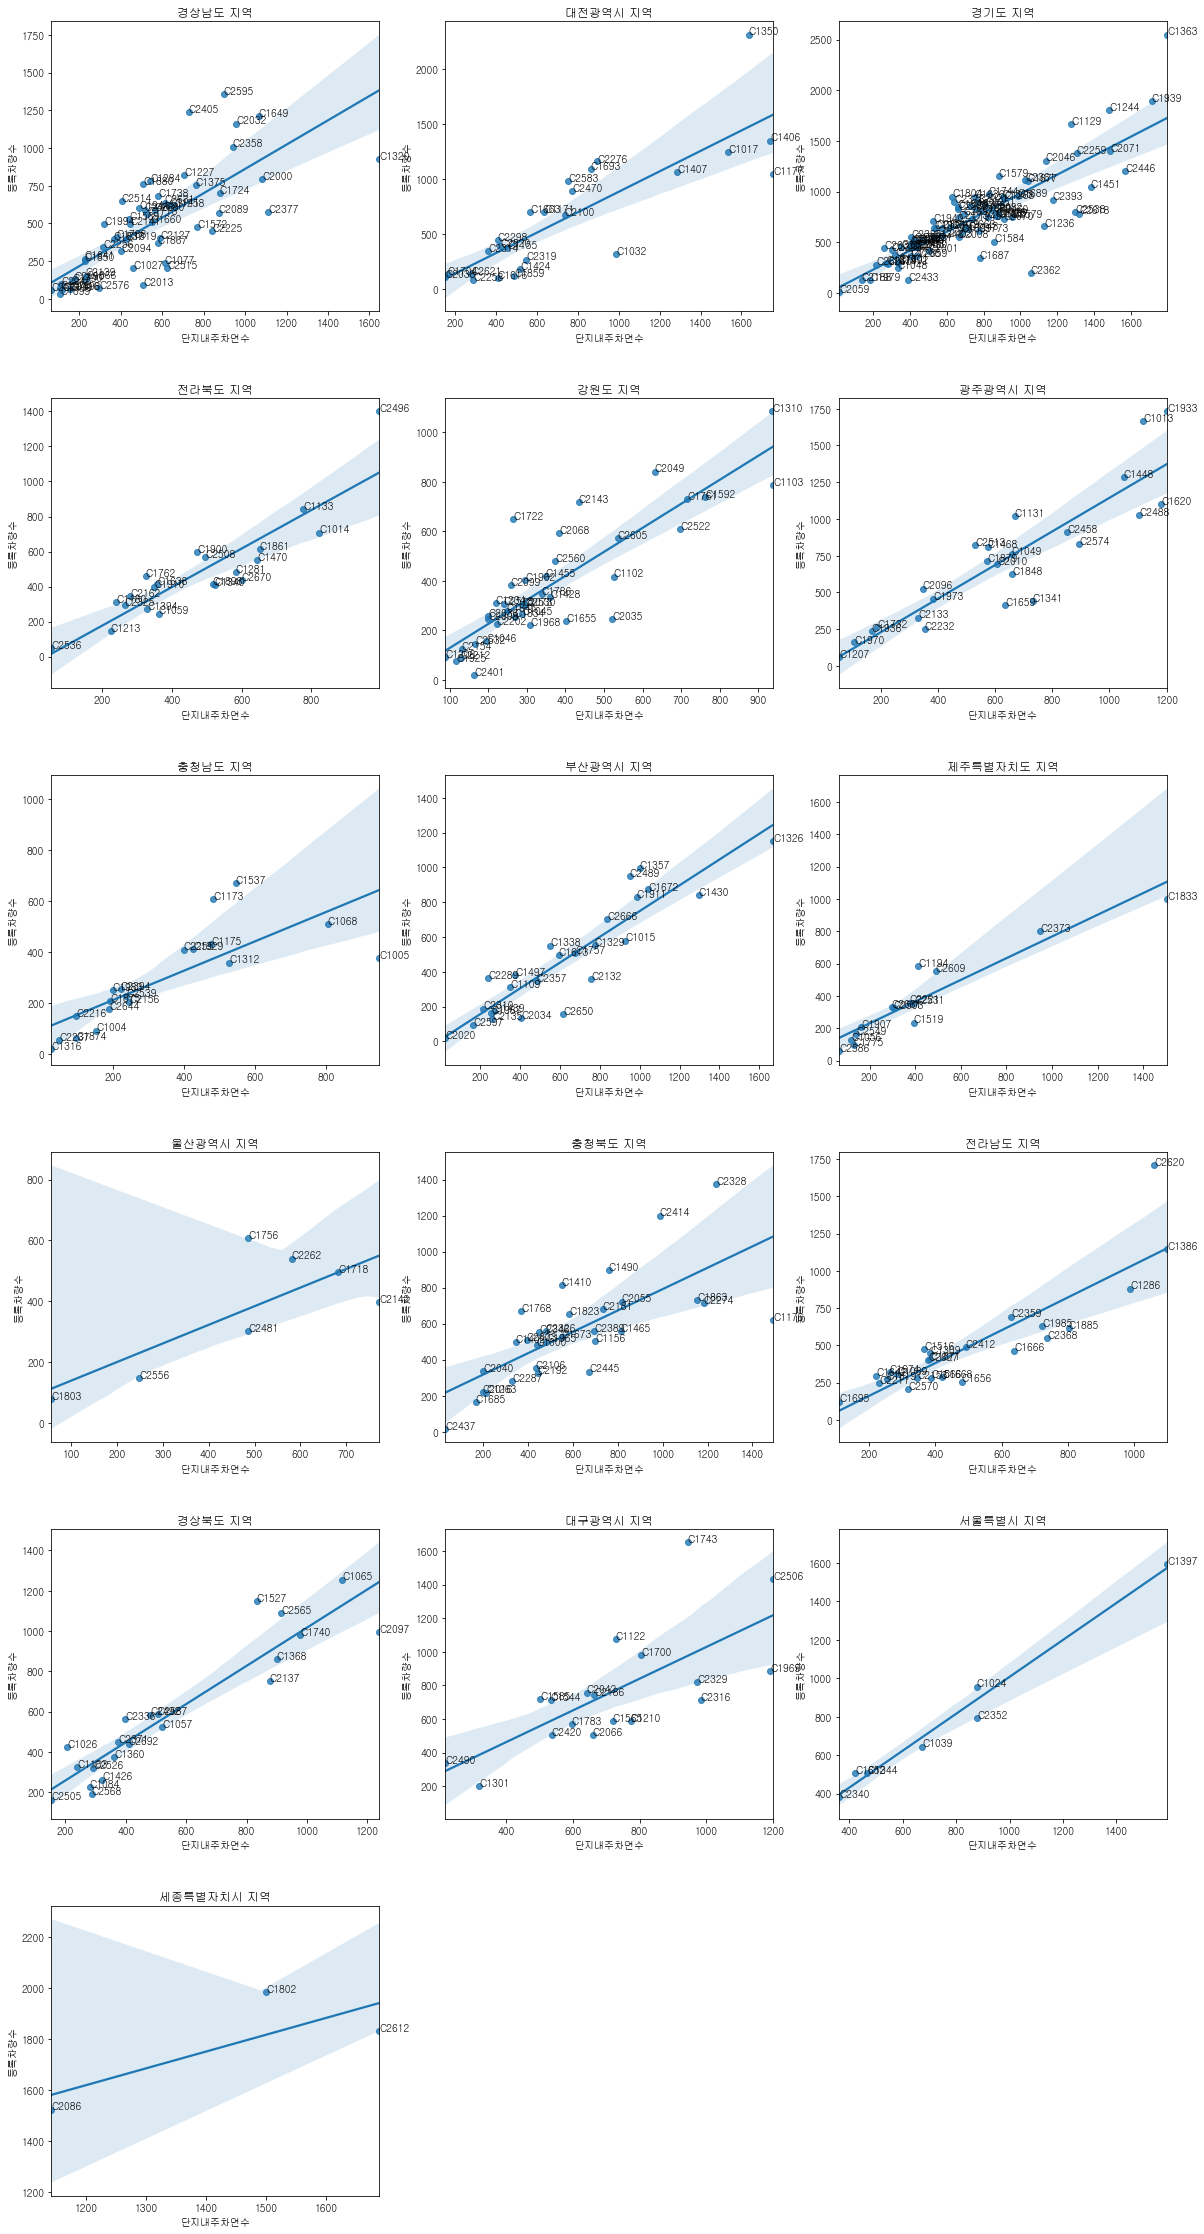

In [112]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_danji.loc[train_danji['지역'] == n], x='단지내주차면수', y='등록차량수')
    for i, code in enumerate(train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지내주차면수'][i],
                              train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

### 산점도(x=총세대수, y=등록차량수)

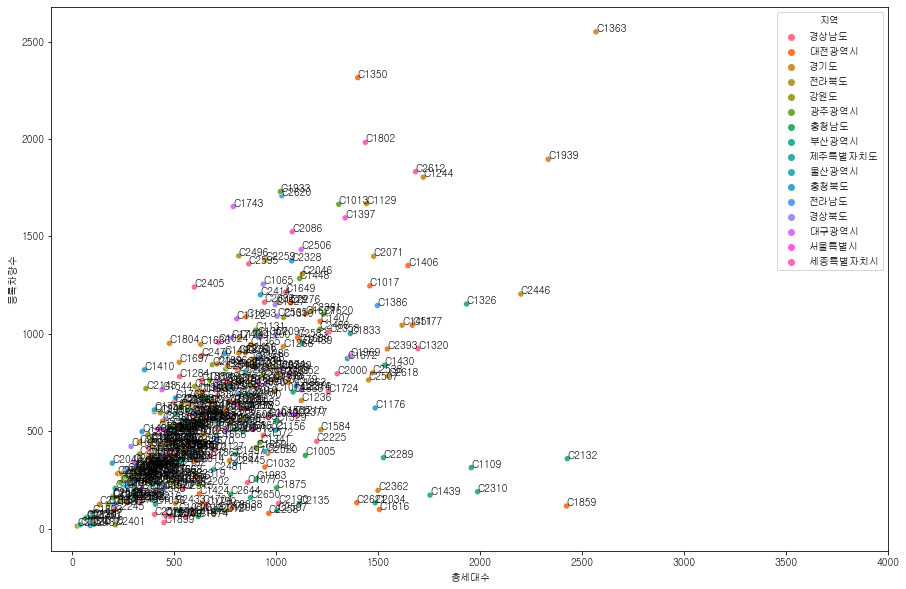

In [113]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='총세대수', y='등록차량수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['총세대수'][i], train_danji['등록차량수'][i]))
plt.xlim(right=4000)
plt.show()

In [121]:
train_danji.loc[train_danji['단지코드'].isin(['C1859', 'C1616', 'C2258', 'C1899', 'C2621', 'C2034', 'C1439', 'C2310']),
               ['단지코드', '총세대수', '단지내주차면수', '등록차량수', '지역']]

단지코드  총세대수  단지내주차면수  등록차량수     지역
21  C2621  1396    277.0  133.0  대전광역시
24  C1616  1507    407.0   98.0  대전광역시
26  C2258   965    287.0   78.0  대전광역시
29  C1859  2424    487.0  116.0  대전광역시
38  C2034  1486    405.0  132.0  부산광역시
43  C2310  1988    217.0  189.0  부산광역시
46  C1439  1755    270.0  172.0  부산광역시
49  C1899   451    109.0   31.0   경상남도

- 총세대수에 비해 등록차량수가 너무 적은 단지들이 있습니다.
- 이 단지들은 총세대수에 비해 단지내주차면수 또한 매우 적으며, 그에 비해 등록차량수도 더욱 적습니다.
- 특이한 점은 대전광역시와 부산광역시에 많이 분포하고 있다는 점입니다.

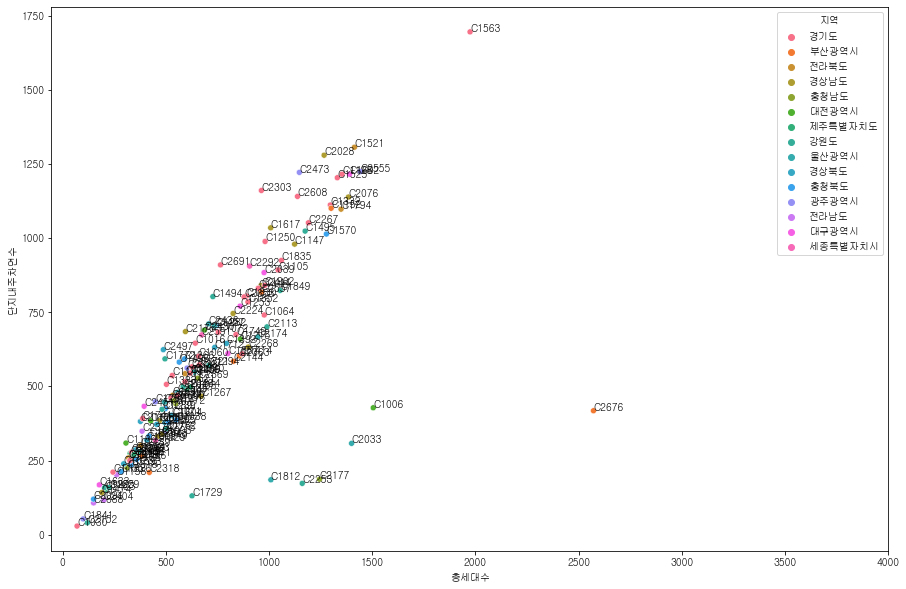

In [125]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=test_danji, x='총세대수', y='단지내주차면수', hue='지역')
for i, code in enumerate(test_danji['단지코드']):
    plots.annotate(code, (test_danji['총세대수'][i], test_danji['단지내주차면수'][i]))
plt.xlim(right=4000)
plt.show()

In [129]:
test_danji.loc[test_danji['단지코드'].isin(['C1729', 'C1812', 'C2253', 'C2177', 'C2033', 'C1006', 'C2676']),
               ['단지코드', '총세대수', '단지내주차면수', '지역']]

단지코드  총세대수  단지내주차면수     지역
11  C1006  1505    428.0  대전광역시
14  C2676  2572    418.0  부산광역시
18  C2177  1245    187.0   충청남도
20  C2033  1400    308.0  울산광역시
25  C1812  1009    185.0  울산광역시
26  C2253  1161    173.0    강원도
34  C1729   627    131.0    강원도

- 테스트 단지는 더욱 두드러집니다.
- 추측컨데 해당 단지는 1995년 이전에 지어진 건물이어야만 합니다. 법적으로 이렇게 적은 주차면수는 허가가 나지 않을 것이기 때문입니다.

### 레그플롯_지역별(x=총세대수, y=등록차량수)

지역별로 살펴봐야겠습니다. 지역별로 법정주차대수가 다르기 때문에 그래프가 다르게 나타날 수 있습니다.

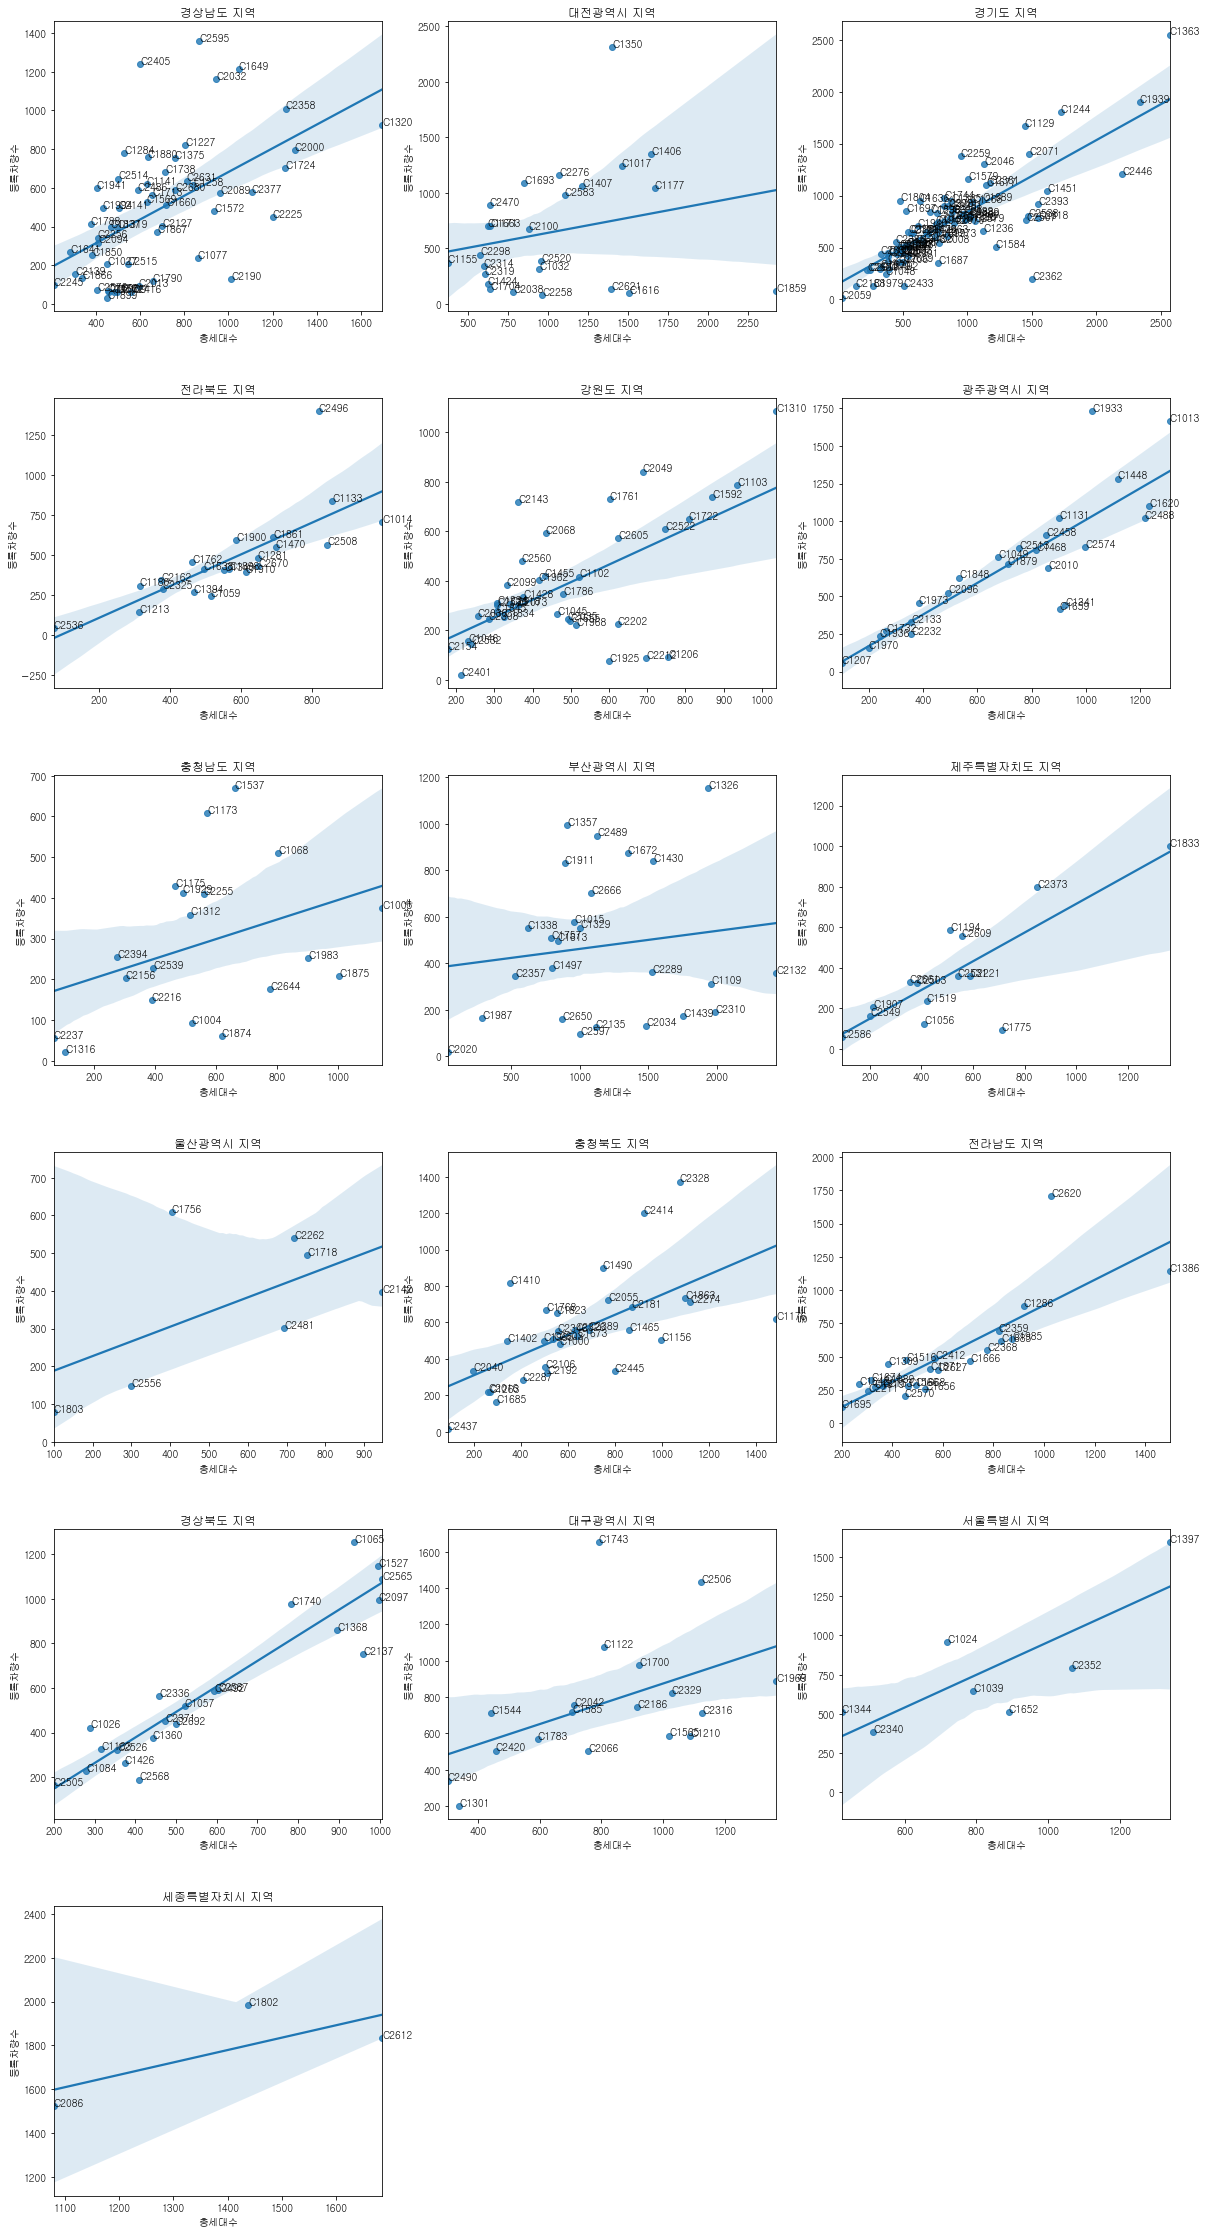

In [130]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_danji.loc[train_danji['지역'] == n], x='총세대수', y='등록차량수')
    for i, code in enumerate(train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['총세대수'][i],
                              train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

- 보통은 법정주차대수 때문에 총세대수와 주차면수는 곧은 선형관계를 띄게 되어 있습니다.
- 그런데 우측 하단에 그 관계를 벗어나는 군집이 나타납니다. 대전, 강원도, 충남, 부산이 특히 그렇습니다.
- 가설은 아주 오래된 아파트이거나, 자차를 소유하지 않은 주민들이 많이 사는 지역일 가능성입니다.

### 산점도(x=건축연면적, y=등록차량수)

In [131]:
temp = train.groupby(['단지코드']).sum().reset_index()
train_size = pd.merge(train_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

In [132]:
temp = test.groupby(['단지코드']).sum().reset_index()
test_size = pd.merge(test_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

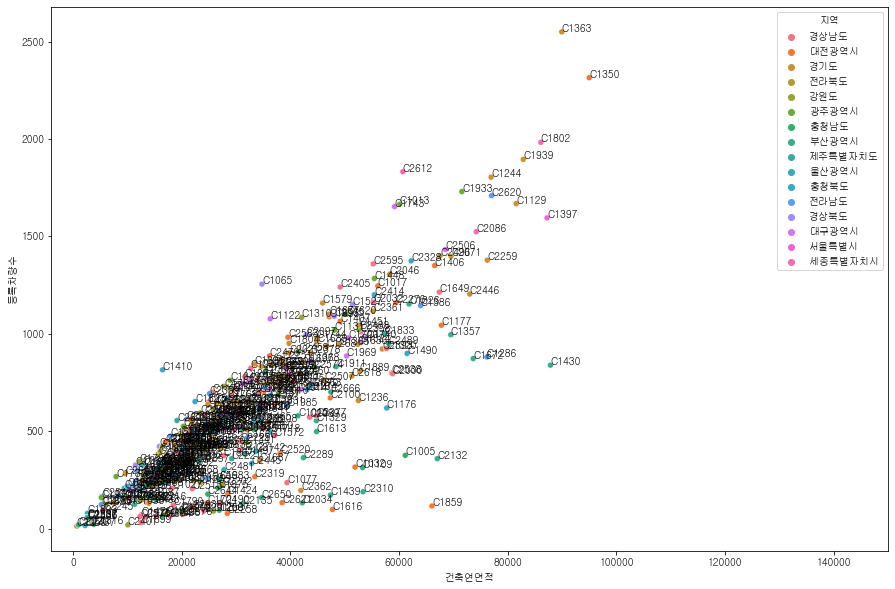

In [133]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_size, x='건축연면적', y='등록차량수', hue='지역')
for i, code in enumerate(train_size['단지코드']):
    plots.annotate(code, (train_size['건축연면적'][i], train_size['등록차량수'][i]))
plt.xlim(right=150000)
plt.show()

- C1859, C1616 등 총세대수에 비해 등록차량수가 너무 적었던 단지들이 그대로 나타납니다.
- 총세대수가 많을수록 건축연면적이 넓기 때문입니다.

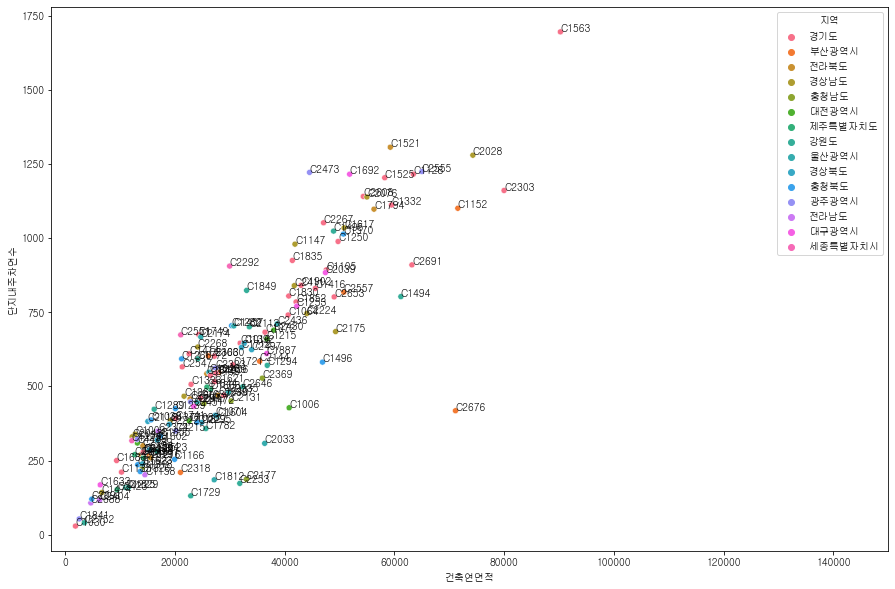

In [134]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=test_size, x='건축연면적', y='단지내주차면수', hue='지역')
for i, code in enumerate(test_size['단지코드']):
    plots.annotate(code, (test_size['건축연면적'][i], test_size['단지내주차면수'][i]))
plt.xlim(right=150000)
plt.show()

### 레그플롯_지역별(x=건축연면적, y=등록차량수)

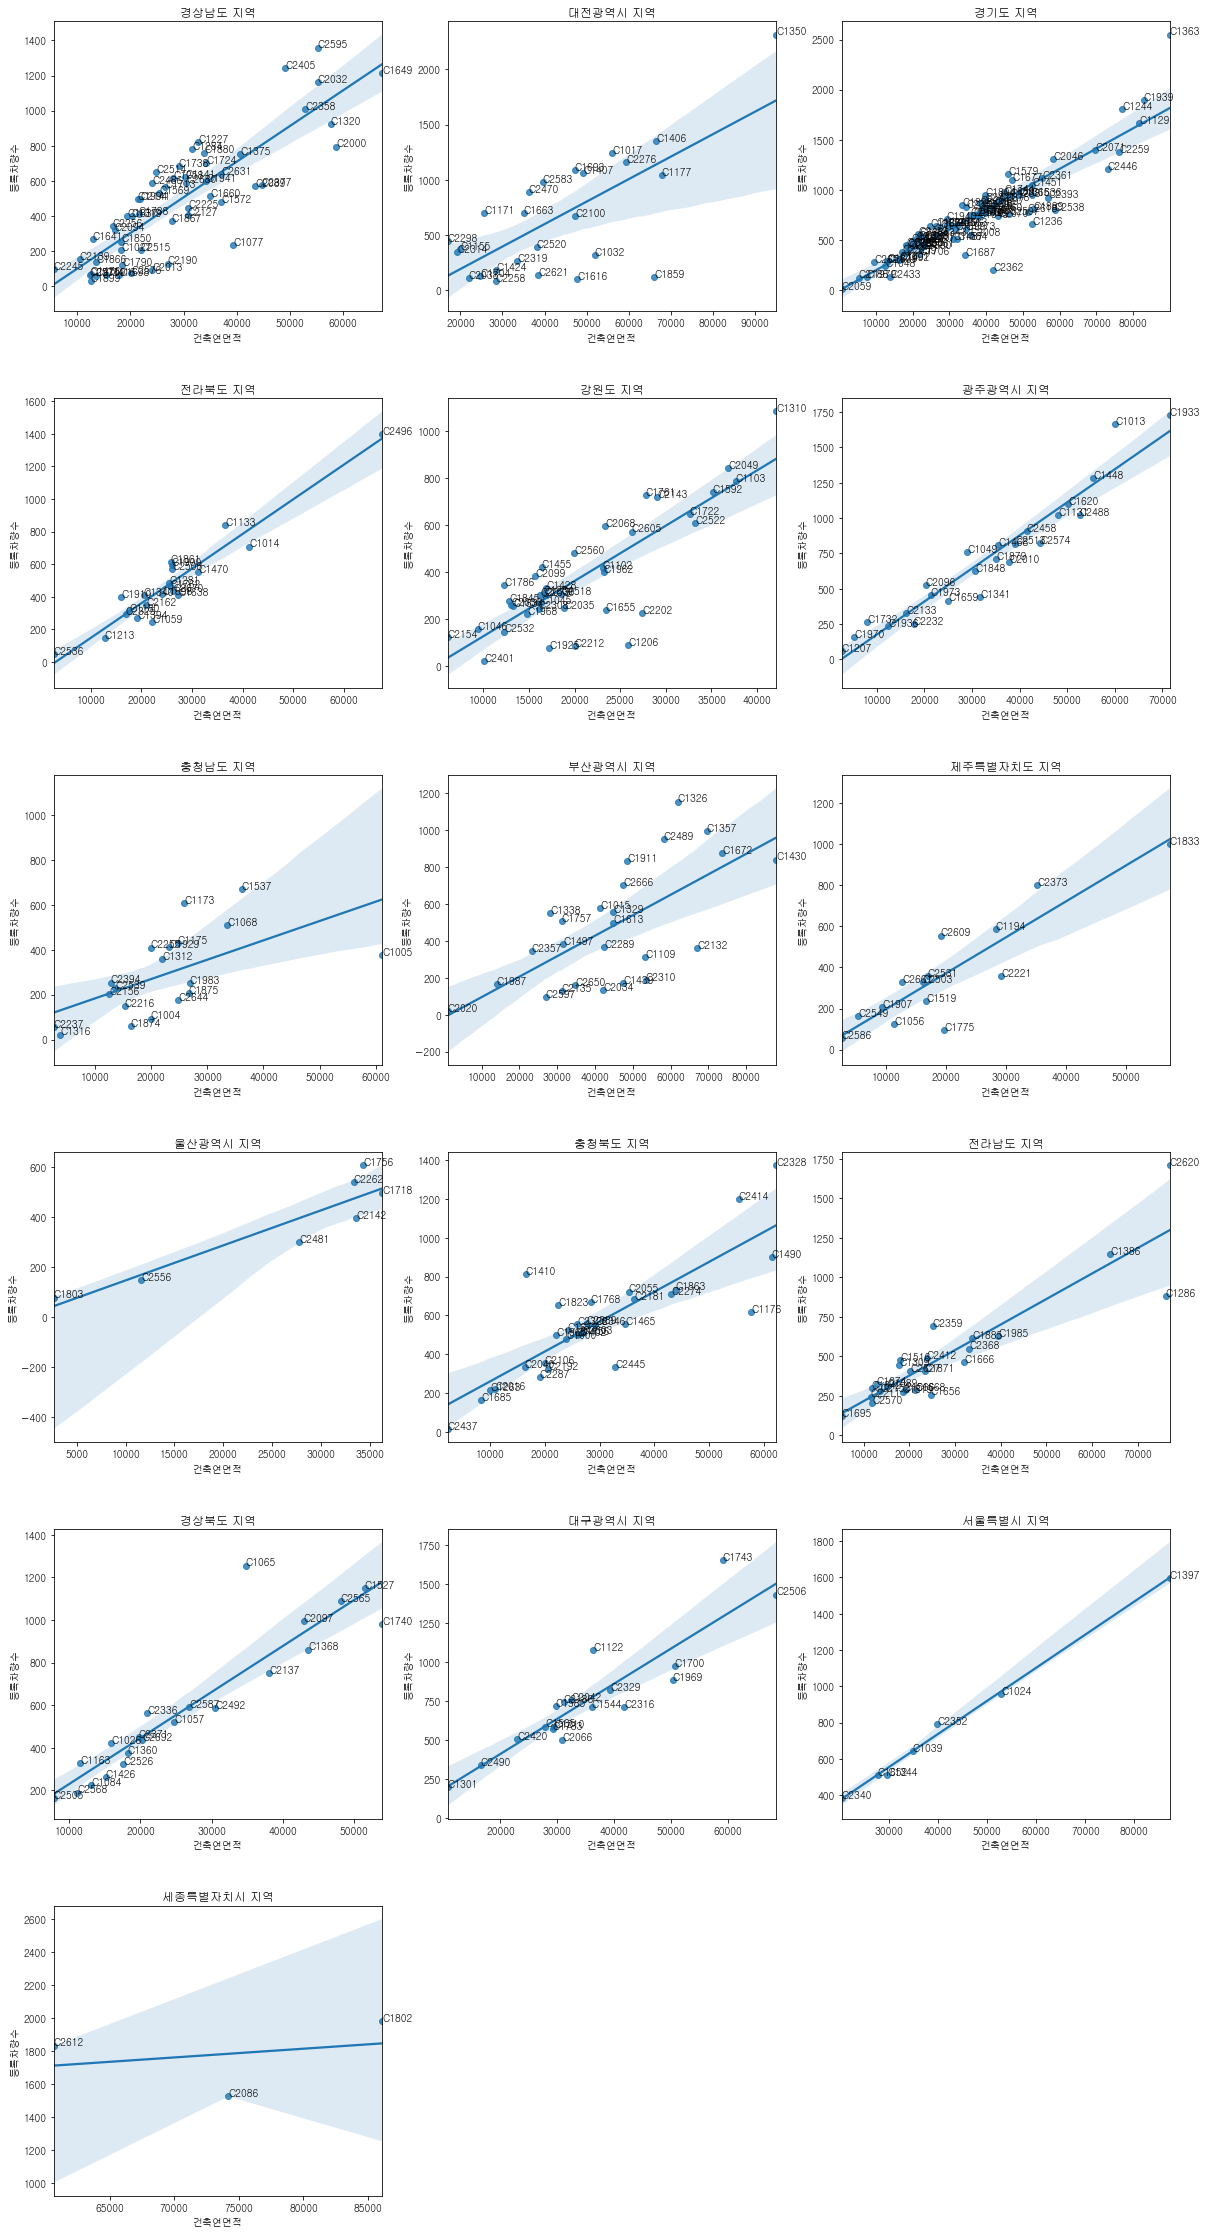

In [135]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_size['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_size.loc[train_size['지역'] == n], x='건축연면적', y='등록차량수')
    for i, code in enumerate(train_size.loc[train_size['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_size.loc[train_size['지역'] == n].reset_index(drop=True)['건축연면적'][i],
                              train_size.loc[train_size['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

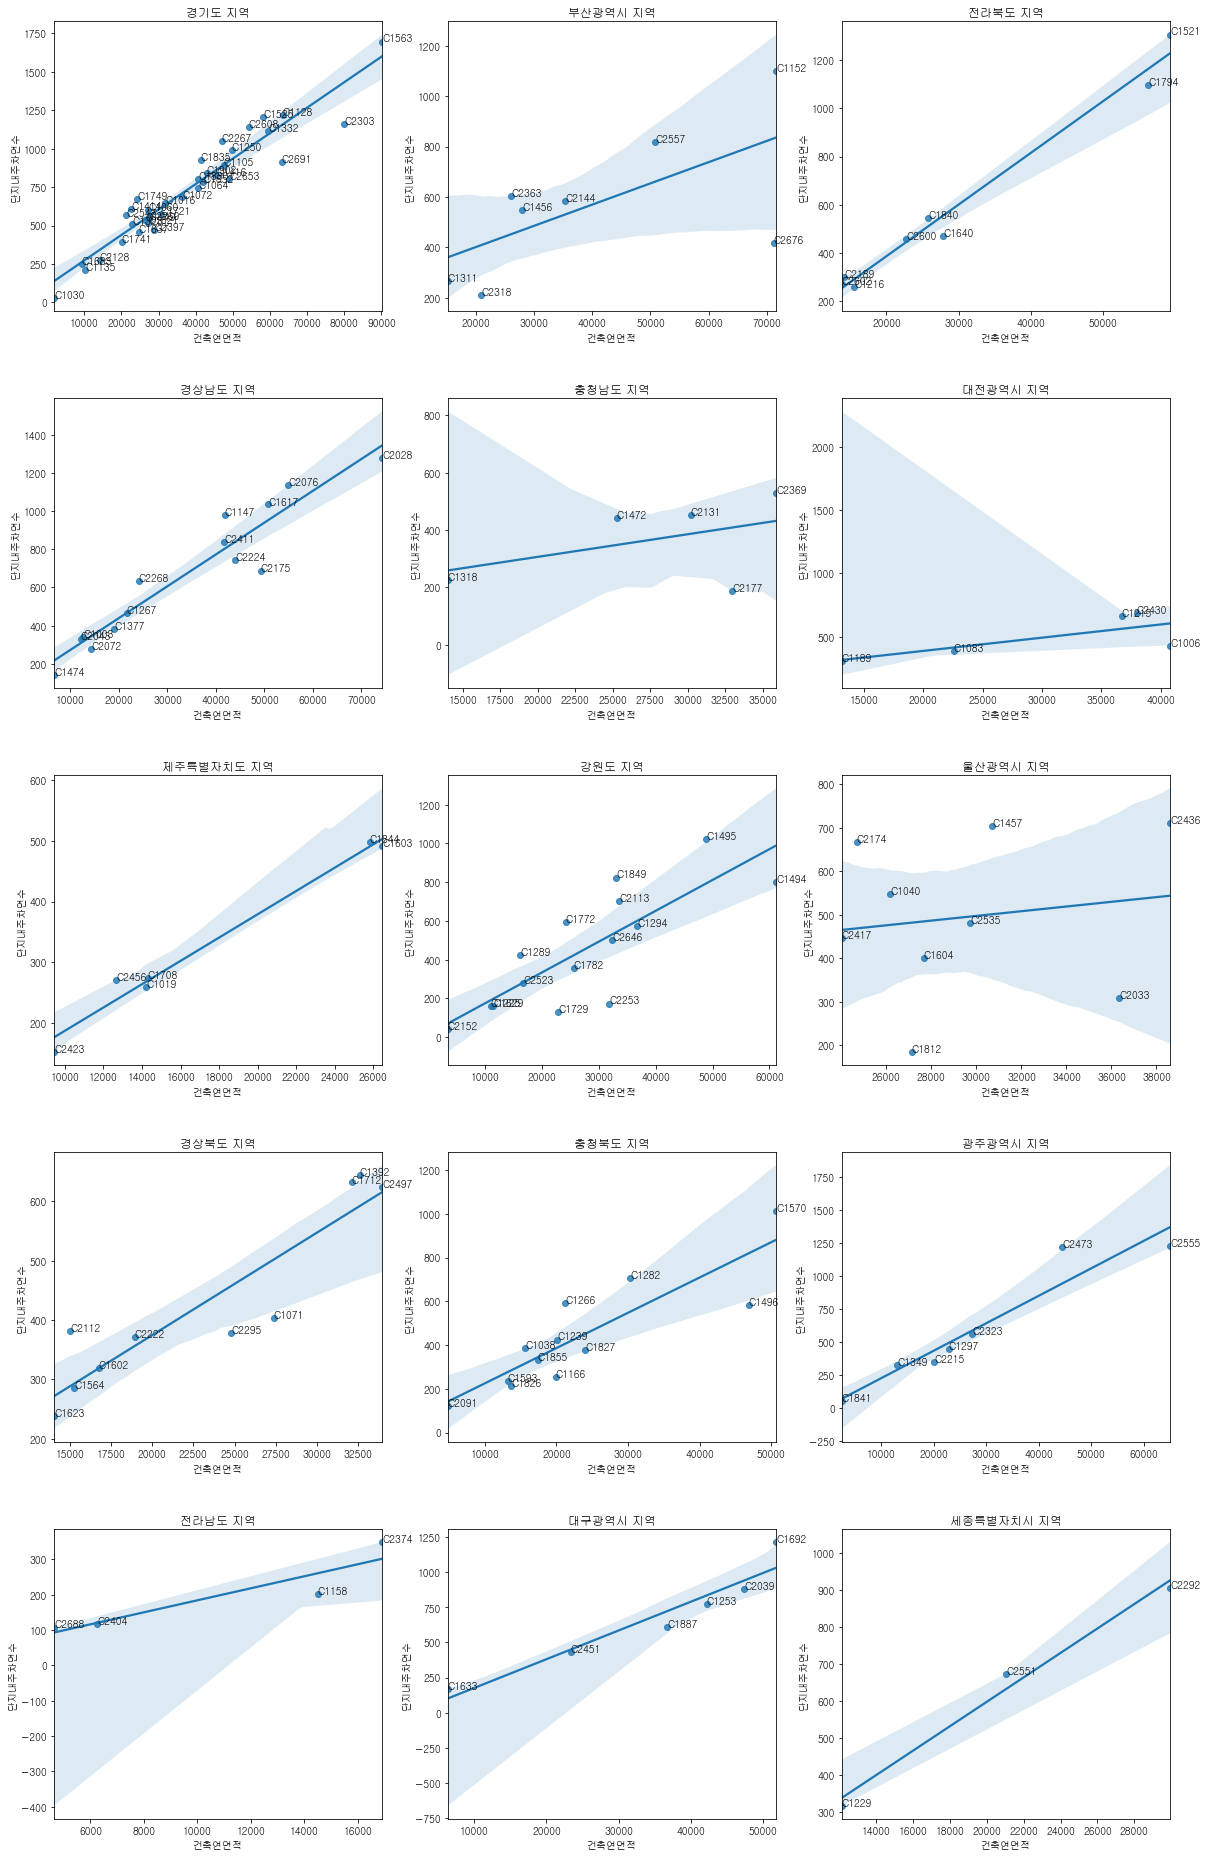

In [136]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(test_size['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=test_size.loc[test_size['지역'] == n], x='건축연면적', y='단지내주차면수')
    for i, code in enumerate(test_size.loc[test_size['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (test_size.loc[test_size['지역'] == n].reset_index(drop=True)['건축연면적'][i],
                              test_size.loc[test_size['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

### 바차트 (총세대수주차면수비 & 건축연면적주차면수비)

In [137]:
train_size['등록차량수/총세대수'] = train_size['등록차량수'] / train_size['총세대수']
train_size['등록차량수/건축연면적'] = (train_size['등록차량수'] / train_size['건축연면적']) * 100

In [138]:
train_size.nlargest(5, '등록차량수/총세대수')

단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수   등록차량수     건축연면적  \
193  C1410   356   충청북도  10.0  0.0  3.0    550.0   815.0  16485.44   
314  C1743   791  대구광역시  16.0  1.0  1.0    944.0  1653.0  59167.83   
297  C2405   600   경상남도  22.0  0.0  8.0    728.0  1240.0  49163.00   
269  C1804   478    경기도   3.0  0.0  3.0    629.0   951.0  39754.25   
354  C2143   363    강원도   2.0  0.0  2.0    434.0   719.0  29048.58   

     등록차량수/총세대수  등록차량수/건축연면적  
193    2.289326     4.943756  
314    2.089760     2.793748  
297    2.066667     2.522222  
269    1.989540     2.392197  
354    1.980716     2.475164

- C1410 단지는 총세대수 356세대에 등록차량수가 815대인데, 이러면 세대당 2대가 넘는다는 겁니다.
- 여기까지는 그럴 수 있다고 치지만, 건축연면적입니다. 건축연면적비가 크다는 것은 대형평형수가 많지 않다는 뜻인데, 이 경우에는 세대당 2대를 보유한다는 것이 납득이 힘들기도 합니다.

In [139]:
train_size.nsmallest(5, '등록차량수/총세대수')

단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수  등록차량수     건축연면적  등록차량수/총세대수  \
29  C1859  2424  대전광역시   1.0  1.0  4.0    487.0  116.0  66049.65    0.047855   
24  C1616  1507  대전광역시   1.0  0.0  2.0    407.0   98.0  47743.56    0.065030   
49  C1899   451   경상남도   0.0  0.0  4.0    109.0   31.0  12524.94    0.068736   
26  C2258   965  대전광역시  13.0  0.0  3.0    287.0   78.0  28400.76    0.080829   
38  C2034  1486  부산광역시   2.0  1.0  3.0    405.0  132.0  42187.95    0.088829   

    등록차량수/건축연면적  
29     0.175625  
24     0.205263  
49     0.247506  
26     0.274641  
38     0.312886

- 반대로 세대당 0.1대도 보유하지 않은 단지가 있습니다.

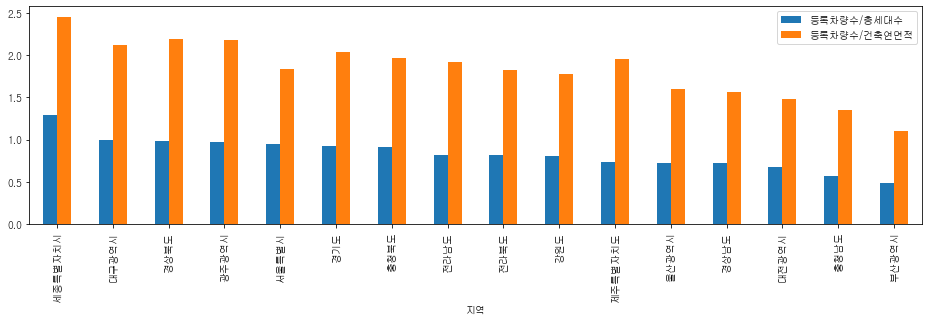

In [140]:
(train_size
 .groupby(['지역'])[['등록차량수/총세대수', '등록차량수/건축연면적']]
 .mean()
 .sort_values(by='등록차량수/총세대수', ascending=False)
 .plot(kind='bar', figsize=(16, 4)))
plt.show()

- 총세대수와 건축연면적은 보통 양의 상관성을 띕니다. 총세대수가 많을수록 건축연면적이 클 수 밖에 없기 때문입니다.
- 다만 대형평형 세대가 적으면 총세대수가 많더라도 건축연면적이 크지 않을 수 있는데, 이걸 비교하기 위한 차트입니다.


- 총세대수비를 기준으로 오더링이 되어 있습니다. 그런데 건축연면적비가 높거나 낮으면 눈여겨 봐야 합니다.
- 제주시 같은 경우는 건축연면적비는 총세대수비에 비해서 높습니다. 즉, 다른 지역보다 소형평형 단지가 많다는 것을 의미합니다.
- 서울특별시같은 경우는 건축연면적비가 총세대수비에 비해서 낮습니다. 즉, 다른 지역보다 대형평형 단지가 많다는 것을 의미합니다.
- 이는 대구도 마찬가지입니다.


- 대형평형 단지가 많은 지역: 서울, 대구
- 소형평형 단지가 많은 지역: 제주

In [145]:
train_size['등록차량수/총세대수'] = train_size['등록차량수'] / train_size['총세대수']
train_size['등록차량수/주차면수'] = train_size['등록차량수'] / train_size['단지내주차면수']

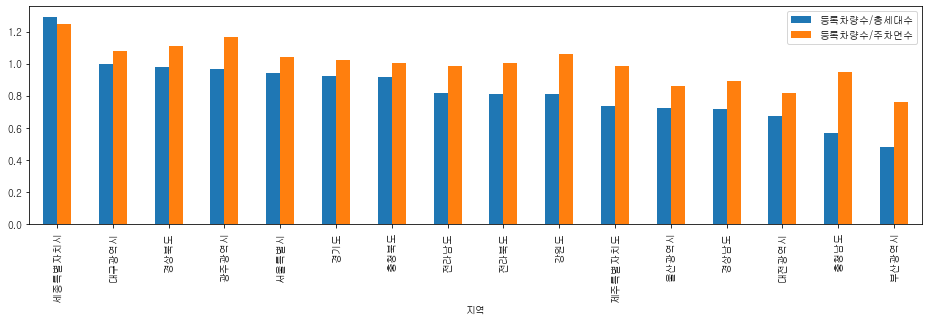

In [147]:
(train_size
 .groupby(['지역'])[['등록차량수/총세대수', '등록차량수/주차면수']]
 .mean()
 .sort_values(by='등록차량수/총세대수', ascending=False)
 .plot(kind='bar', figsize=(16, 4)))
plt.show()

- 총세대수비와 함께 주차면수비를 살펴보도록 하겠습니다.
- 앞서 살펴봤듯이 총세대수와 주차면수는 양의 상관성을 띕니다. 일부 벗어나는 단지들이 존재하는 지역일수록 과하게 높거나 낮을 것입니다.


- 전체적으로 주차면수비가 총세대수비보다 높게 형성이 됩니다.
- 총세대부시가 낮아질수록 주차면수비도 낮아져야 하는데, 차이가 점점 벌어지는 것을 알 수 있습니다.


- 세종시는 오히려 주차면수비가 총세대수비보다 작습니다. 즉, 다른 지역보다 총세대수에 비해 주차면수가 많다는 것입니다.
- 광주광역시, 강원도, 충청남도 등의 지역은 총세대수비에 비해서 주차면수비가 과하게 높습니다. 즉, 총세대수에 비해 주차면수가 적다는 것입니다.


- 총세대수에 비해 주차면수가 많은 지역: 세종, 대구, 서울
- 총세대수에 비해 주차면수가 적은 지역: 광주, 강원도, 제주, 충남

### 공급유형 바차트

In [148]:
train_reqruit = pd.pivot_table(train, index='단지코드', columns='공급유형', values='전용면적별세대수', aggfunc=np.sum, fill_value=0)
train_reqruit.head()

공급유형   공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  장기전세  행복주택
단지코드                                                                         
C1000     0          0          0         0         0   566     0     0     0
C1004     0          0          0         0         0     0   504     0     0
C1005     0          0          0         0         0  1144     0     0     0
C1013     0          0          0         0         0  1308     0     0     0
C1014     0          0          0         0         0   996     0     0     0

In [149]:
train_reqruit2 = pd.merge(train_reqruit.reset_index(), train[['단지코드', '지역', '등록차량수']],
                          how='inner', on='단지코드').drop_duplicates().set_index('단지코드')

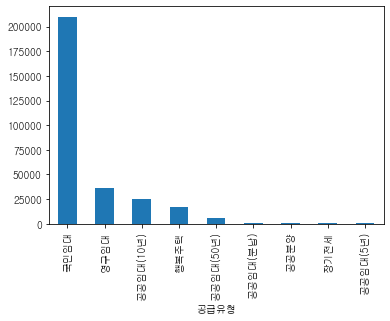

In [150]:
train_reqruit.sum(axis=0).sort_values(ascending=False).plot(kind='bar')
plt.show()

- 국민임대가 20만호가 넘으며 압도적인 비중입니다. 그 뒤로 영구임대, 공공임대, 행복주택 등이 있습니다.

In [151]:
test['공급유형'].unique()

array(['국민임대', '영구임대', '공공임대(50년)', '공공임대(10년)', '공공임대(분납)', '행복주택'],
      dtype=object)

In [152]:
train_reqruit2.nlargest(10, '공공임대(10년)')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  장기전세  행복주택  \
단지코드                                                                            
C1129     0       1444          0         0         0     0     0     0     0   
C1802     0       1438          0         0         0     0     0     0     0   
C2506     0       1124          0         0         0     0     0     0     0   
C2086     0       1080          0         0         0     0     0     0     0   
C2328     0       1077          0         0         0     0     0     0     0   
C2620     0       1029          0         0         0     0     0     0     0   
C1933     0       1022          0         0         0     0     0     0     0   
C2259     0        947          0         0         0     0     0     0     0   
C2414     0        924          0         0         0     0     0     0     0   
C1700     0        922          0         0         0     0     0     0     0   

            지역   등록차량수  
단지코드                    
C1129      경기도  1668.0  
C1802  세종특별자치시  1983.0  
C2506    대구광역시  1433.0  
C2086  세종특별자치시  1524.0  
C2328     충청북도  1374.0  
C2620     전라남도  1709.0  
C1933    광주광역시  1730.0  
C2259      경기도  1378.0  
C2414     충청북도  1200.0  
C1700    대구광역시   979.0

In [153]:
train_reqruit2.nlargest(10, '공공임대(50년)')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  장기전세  행복주택  \
단지코드                                                                            
C2520     0          0        960         0         0     0     0     0     0   
C1497     0          0        802         0         0     0     0     0     0   
C1424     0          0        624         0         0     0     0     0     0   
C2202     0          0        623         0         0     0     0     0     0   
C2221     0          0        590         0         0     0     0     0     0   
C2340     0          0        512         0         0     0     0     0     0   
C1722     0          0        505         0         0     0   298     0     0   
C2216     0          0        390         0         0     0     0     0     0   
C2644     0          0        387         0         0     0   388     0     0   
C1850     0          0        385         0         0     0     0     0     0   

            지역  등록차량수  
단지코드                   
C2520    대전광역시  386.0  
C1497    부산광역시  382.0  
C1424    대전광역시  179.0  
C2202      강원도  226.0  
C2221  제주특별자치도  359.0  
C2340    서울특별시  382.0  
C1722      강원도  649.0  
C2216     충청남도  149.0  
C2644     충청남도  177.0  
C1850     경상남도  254.0

In [154]:
req_cols = ['공공임대(10년)', '공공임대(50년)', '공공임대(분납)',
       '영구임대', '장기전세', '행복주택']

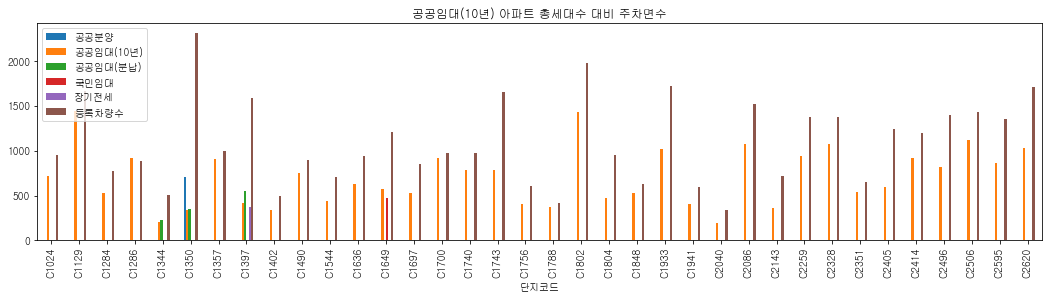

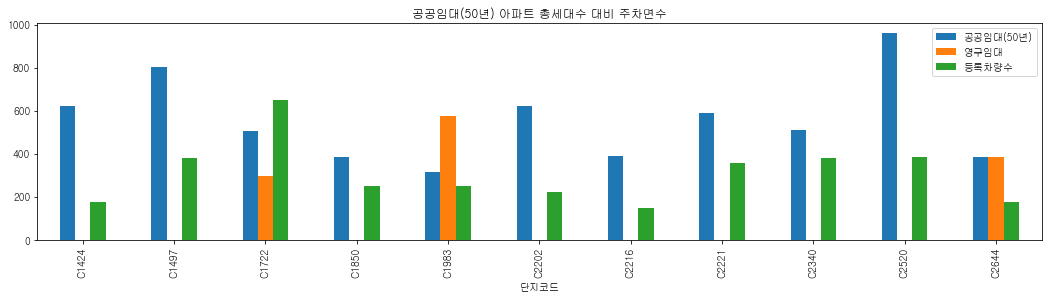

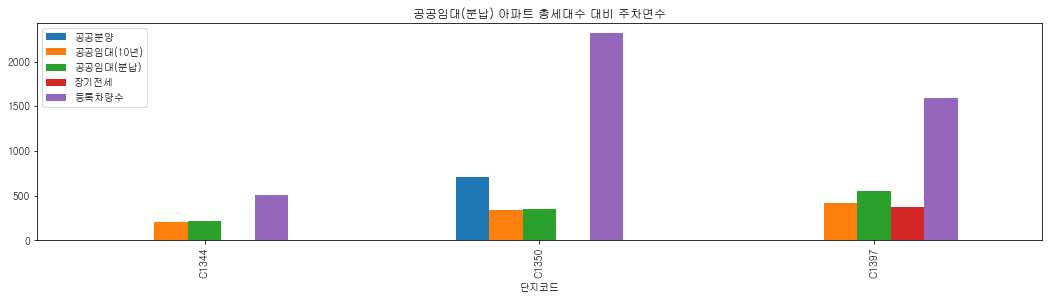

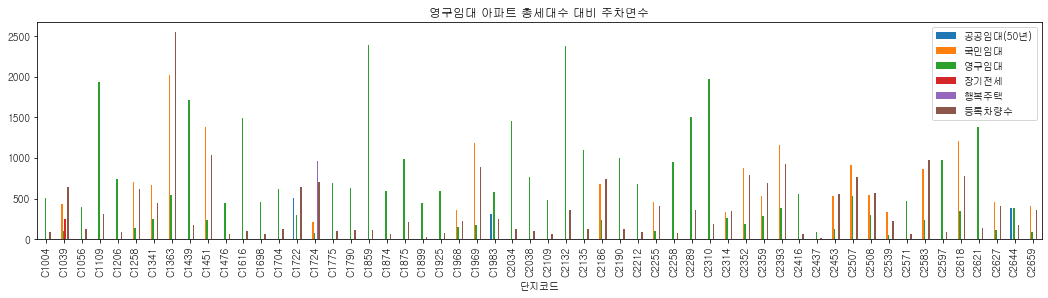

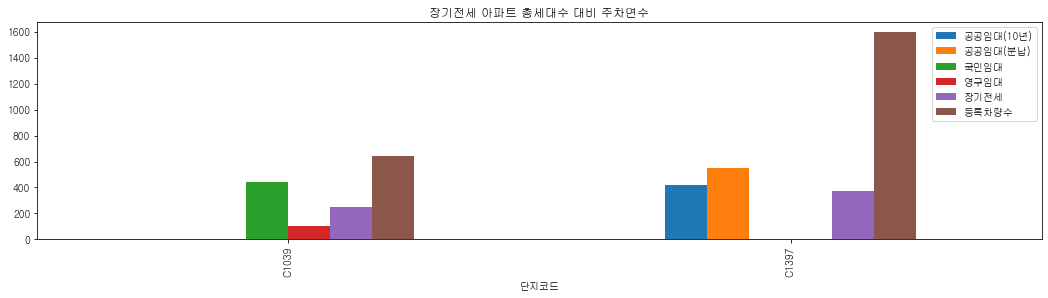

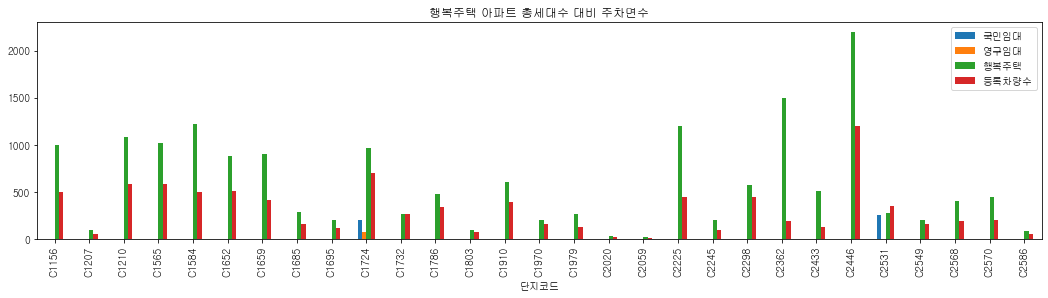

In [155]:
for col in req_cols:
    train_reqruit2.loc[train_reqruit2[col] != 0,
                      [x for x in train_reqruit2.columns if train_reqruit2.loc[train_reqruit2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(18, 4))
    plt.title('{} 아파트 총세대수 대비 주차면수'.format(col))
    plt.show()

- 특이한 점이 많습니다.
1. 임대상가가 있는 아파트는 무조건 영구임대단지다. 총세대수에 비해 주차면수도 굉장히 적다.
2. 공공임대(50년)이 있는 단지는 주차면수가 총세대수에 비해 굉장히 적다.
3. 행복주택은 보통 행복주택만 있습니다.
4. 공공분양, 공공임대(5년), 장기전세는 단지가 너무 없습니다.

### 자격유형 바차트

In [156]:
train_qual = pd.pivot_table(train, index='단지코드', columns='자격유형', values='전용면적별세대수', aggfunc=np.sum, fill_value=0)
train_qual.head()

자격유형      A  B    C  E  F  G  H  I  J  K  L  M  N  O
단지코드                                                
C1000   566  0    0  0  0  0  0  0  0  0  0  0  0  0
C1004     0  0  504  0  0  0  0  0  0  0  0  0  0  0
C1005  1144  0    0  0  0  0  0  0  0  0  0  0  0  0
C1013  1308  0    0  0  0  0  0  0  0  0  0  0  0  0
C1014   996  0    0  0  0  0  0  0  0  0  0  0  0  0

In [157]:
train_qual2 = pd.merge(train_qual.reset_index(),
                       train[['단지코드', '지역', '등록차량수']],
                       how='inner', on='단지코드').drop_duplicates().set_index('단지코드')

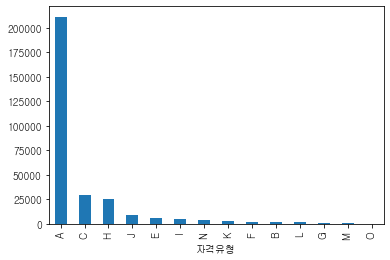

In [158]:
train_qual.sum(axis=0).sort_values(ascending=False).plot(kind='bar')
plt.show()

- A가 압도적으로 많습니다. C, H가 뒤를 잇습니다.

In [159]:
qual_cols = ['C', 'E', 'H', 'I', 'J', 'K', 'L']
qual_cols2 = ['M', 'N', 'O', 'F', 'B', 'G']

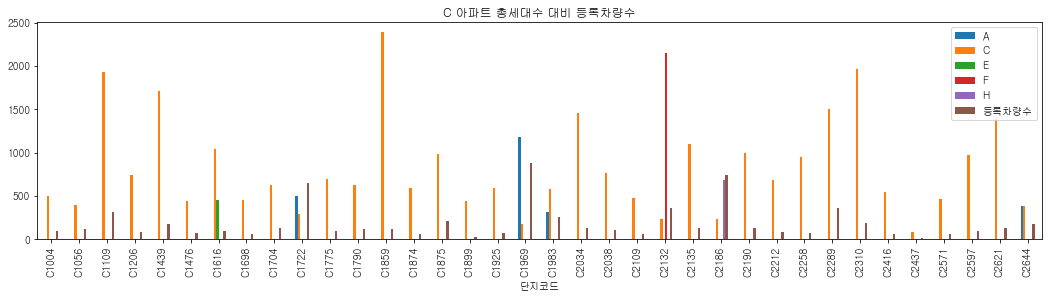

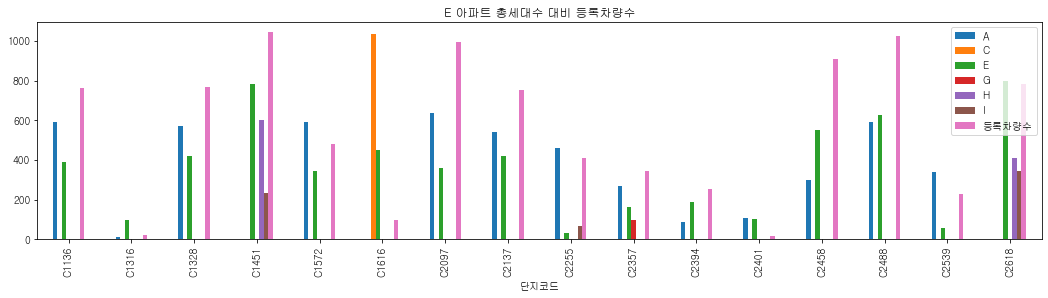

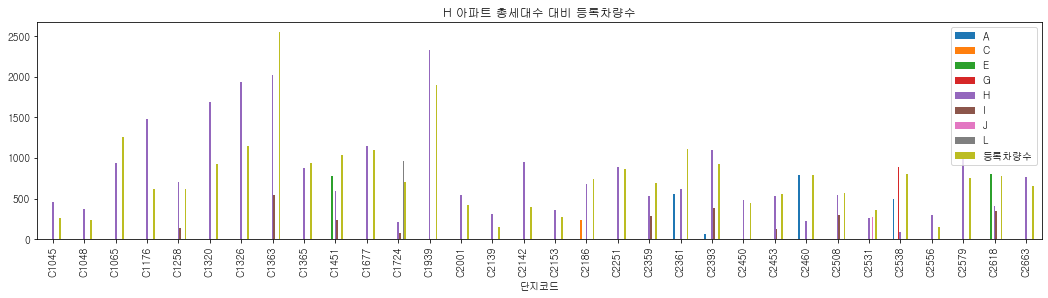

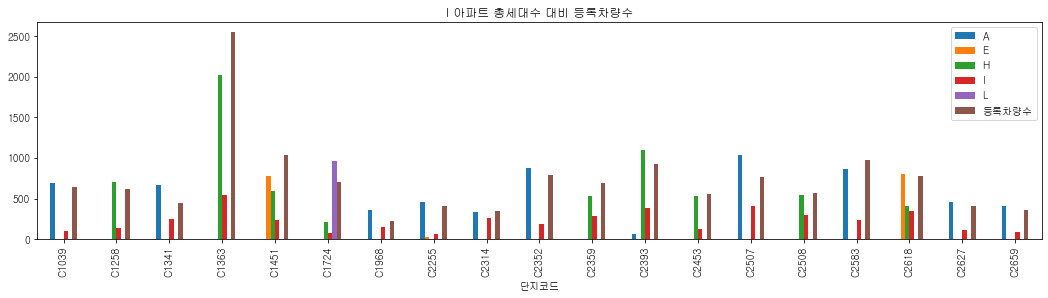

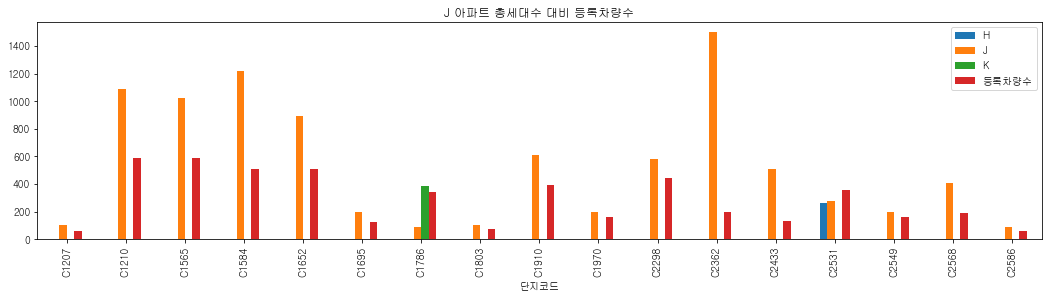

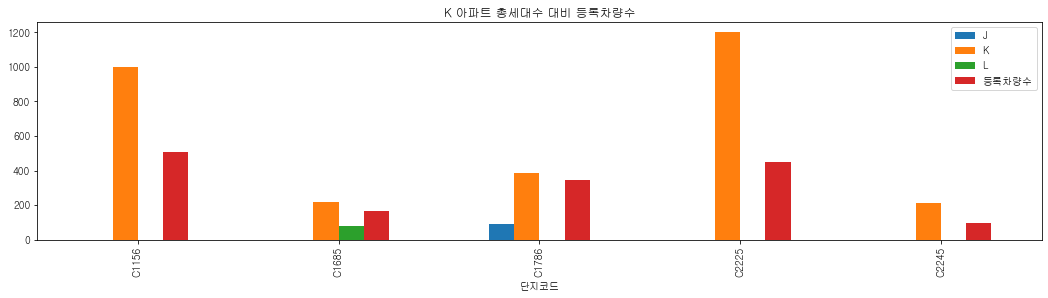

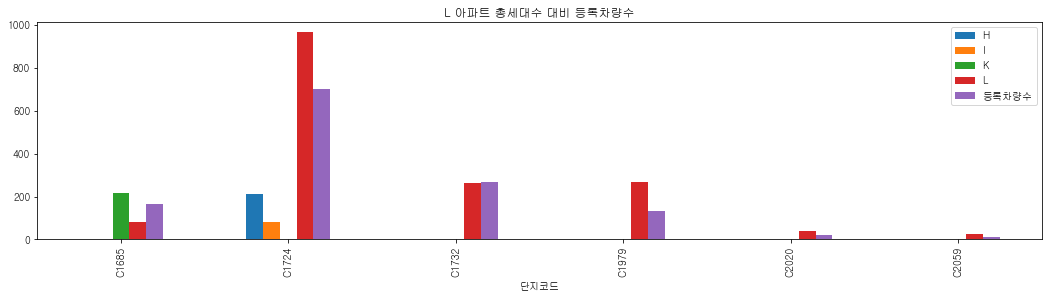

In [160]:
for col in qual_cols:
    train_qual2.loc[train_qual2[col] != 0,
                      [x for x in train_qual2.columns if train_qual2.loc[train_qual2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(18, 4))
    plt.title('{} 아파트 총세대수 대비 등록차량수'.format(col))
    plt.show()

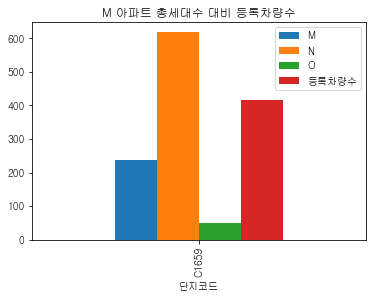

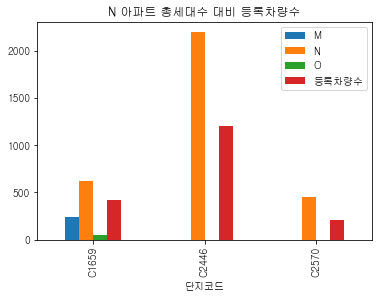

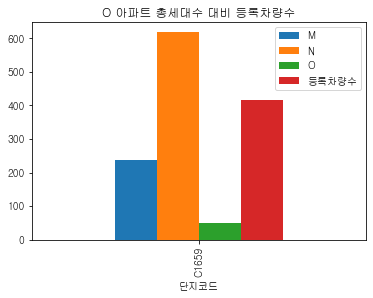

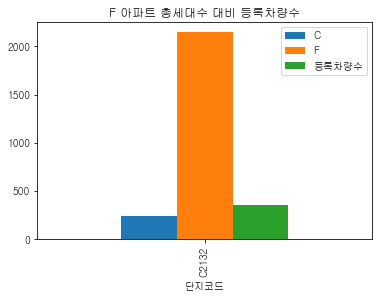

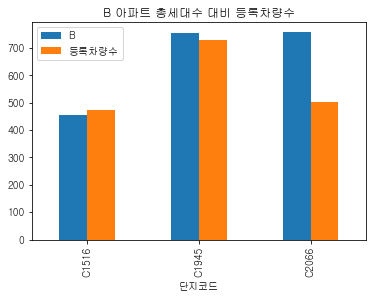

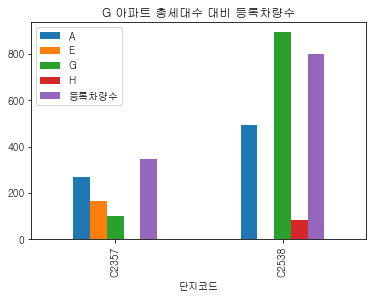

In [161]:
for col in qual_cols2:
    train_qual2.loc[train_qual2[col] != 0,
                      [x for x in train_qual2.columns if train_qual2.loc[train_qual2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(6, 4))
    plt.title('{} 아파트 총세대수 대비 등록차량수'.format(col))
    plt.show()

In [162]:
train_req_qual = pd.merge(train_qual, train_reqruit2.reset_index(), how='inner', on='단지코드').drop_duplicates().set_index('단지코드')
train_req_qual.head()

A  B    C  E  F  G  H  I  J  K  L  M  N  O  공공분양  공공임대(10년)  \
단지코드                                                                    
C1000   566  0    0  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1004     0  0  504  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1005  1144  0    0  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1013  1308  0    0  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1014   996  0    0  0  0  0  0  0  0  0  0  0  0  0     0          0   

       공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  장기전세  행복주택     지역   등록차량수  
단지코드                                                                         
C1000          0         0         0   566     0     0     0   충청북도   481.0  
C1004          0         0         0     0   504     0     0   충청남도    93.0  
C1005          0         0         0  1144     0     0     0   충청남도   376.0  
C1013          0         0         0  1308     0     0     0  광주광역시  1665.0  
C1014          0         0         0   996     0     0     0   전라북도   708.0

In [163]:
for col in req_cols:
    print(col)
    print(tabulate(train_req_qual.loc[train_req_qual[col] != 0,
                                      [x for x in train_req_qual.columns if train_req_qual.loc[train_req_qual[col] != 0][x].sum() != 0]],
                  headers='keys', tablefmt='psql'))
    print("")

공공임대(10년)
+------------+------+------------+------------------+------------------+------------+------------+----------------+--------------+
| 단지코드   |    A |   공공분양 |   공공임대(10년) |   공공임대(분납) |   국민임대 |   장기전세 | 지역           |   등록차량수 |
|------------+------+------------+------------------+------------------+------------+------------+----------------+--------------|
| C1024      |  718 |          0 |              718 |                0 |          0 |          0 | 서울특별시     |          957 |
| C1129      | 1444 |          0 |             1444 |                0 |          0 |          0 | 경기도         |         1668 |
| C1284      |  528 |          0 |              528 |                0 |          0 |          0 | 경상남도       |          780 |
| C1286      |  919 |          0 |              919 |                0 |          0 |          0 | 전라남도       |          881 |
| C1344      |  424 |          0 |              202 |              222 |          0 |          0 | 서울특별시     |          509

In [164]:
for col in ['B', 'C', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']:
    print(col)
    print(tabulate(train_req_qual.loc[train_req_qual[col] != 0,
                                      [x for x in train_req_qual.columns if train_req_qual.loc[train_req_qual[col] != 0][x].sum() != 0]],
                  headers='keys', tablefmt='psql'))
    print("")

B
+------------+-----+------------+------------+--------------+
| 단지코드   |   B |   국민임대 | 지역       |   등록차량수 |
|------------+-----+------------+------------+--------------|
| C1516      | 456 |        456 | 전라남도   |          475 |
| C1945      | 755 |        755 | 경기도     |          730 |
| C2066      | 757 |        757 | 대구광역시 |          503 |
+------------+-----+------------+------------+--------------+

C
+------------+------+------+-----+------+-----+------------------+------------+------------+----------------+--------------+
| 단지코드   |    A |    C |   E |    F |   H |   공공임대(50년) |   국민임대 |   영구임대 | 지역           |   등록차량수 |
|------------+------+------+-----+------+-----+------------------+------------+------------+----------------+--------------|
| C1004      |    0 |  504 |   0 |    0 |   0 |                0 |          0 |        504 | 충청남도       |           93 |
| C1056      |    0 |  400 |   0 |    0 |   0 |                0 |          0 |        400 | 제주특별자치도 |          125 

### 지역별 자격유형별 평균 임대료

In [165]:
mean_rent = train.groupby(['지역', '자격유형'])[['면적당임대료']].mean().reset_index()

In [166]:
mean_rent = mean_rent.loc[mean_rent['면적당임대료'] != 0]

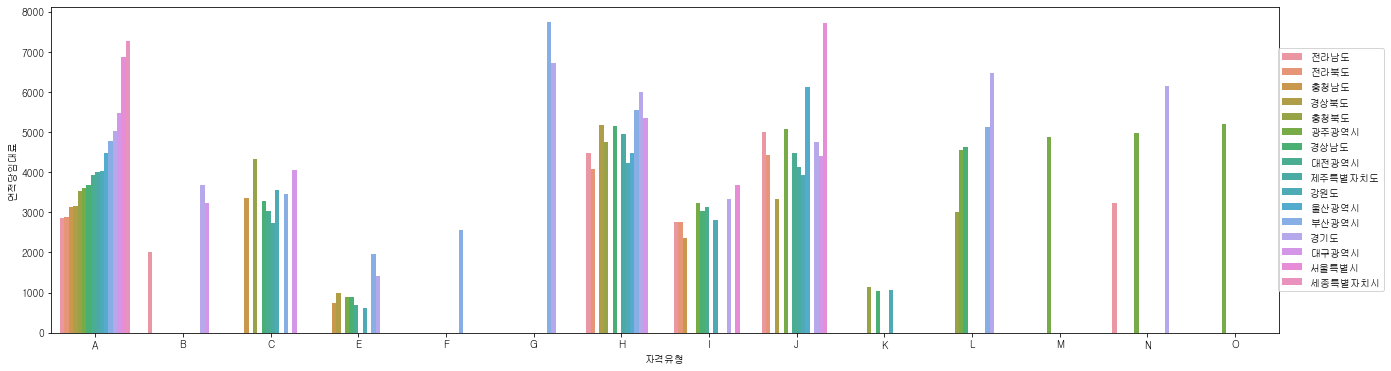

In [167]:
plt.figure(figsize=(22, 6))
sns.barplot(data=mean_rent.sort_values(by=['자격유형', '면적당임대료']),
            x='자격유형', y='면적당임대료', hue='지역')
plt.legend(loc='right', bbox_to_anchor=(1.09, 0.5))
plt.show()

- A, J, G 는 꽤나 높게 형성됩니다.
- 그러나 E, K 는 꽤나 낮게 형성됩니다.

In [168]:
kookmin_A = (
    train
    .loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'A')]
    .groupby(['지역'])['면적당임대료']
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)
kookmin_A

면적당임대료
지역                  
서울특별시    7487.593573
세종특별자치시  5321.380731
경기도      4850.398017
부산광역시    4641.213217
대구광역시    4272.213051
대전광역시    4084.761630
강원도      3940.679162
제주특별자치도  3787.516145
울산광역시    3597.719743
경상남도     3354.302561
충청북도     3103.855208
광주광역시    3058.832986
충청남도     3032.201320
경상북도     3004.303929
전라북도     2688.863480
전라남도     2542.644441

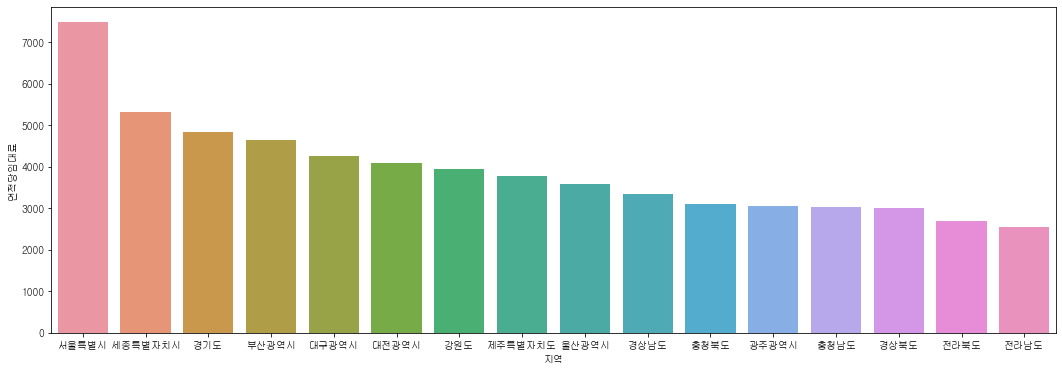

In [169]:
plt.figure(figsize=(18, 6))
sns.barplot(data=kookmin_A, x=kookmin_A.index, y='면적당임대료')
plt.show()

- 국민임대일반지수를 만들어줄 수도 있을 것 같습니다. 표준화를 통해서..
- 지역별 국민임대, A 의 평균 면적당 임대료를 수치로 넣어주면, 해당 지역의 보통의 지가의 수치를 대변할 수 있을 것도 같습니다.
- 당연히 광역시 위주로 높은 순위를 나타낼 것이라 판단했지만, 강원도가 꽤나 높습니다. 의외입니다.

In [170]:
mean_ = kookmin_A['면적당임대료'].mean()
std_ = kookmin_A['면적당임대료'].std()
kookmin_A['국민임대일반지수'] = (kookmin_A['면적당임대료'] - mean_) / std_

In [171]:
kookmin_A

면적당임대료  국민임대일반지수
지역                            
서울특별시    7487.593573  2.871321
세종특별자치시  5321.380731  1.126397
경기도      4850.398017  0.747012
부산광역시    4641.213217  0.578510
대구광역시    4272.213051  0.281273
대전광역시    4084.761630  0.130278
강원도      3940.679162  0.014217
제주특별자치도  3787.516145 -0.109159
울산광역시    3597.719743 -0.262043
경상남도     3354.302561 -0.458120
충청북도     3103.855208 -0.659860
광주광역시    3058.832986 -0.696126
충청남도     3032.201320 -0.717579
경상북도     3004.303929 -0.740051
전라북도     2688.863480 -0.994144
전라남도     2542.644441 -1.111926

In [172]:
mean_rent = train.groupby(['지역', '자격유형'])[['면적당임대료']].mean().reset_index()

In [173]:
# 자격유형이 존재하지 않는 지역이 있는데, 0 으로 동일하게 넣어주겠습니다. 원활한 시각화를 위해.
for region in list(mean_rent['지역'].unique()):
    for qual in list(mean_rent['자격유형'].unique()):
        if len(mean_rent.loc[(mean_rent['지역'] == region) & (mean_rent['자격유형'] == qual)]) == 0:
            mean_rent = mean_rent.append({'지역': region, '자격유형': qual, '면적당임대료': 0}, ignore_index=True)
        else:
            pass

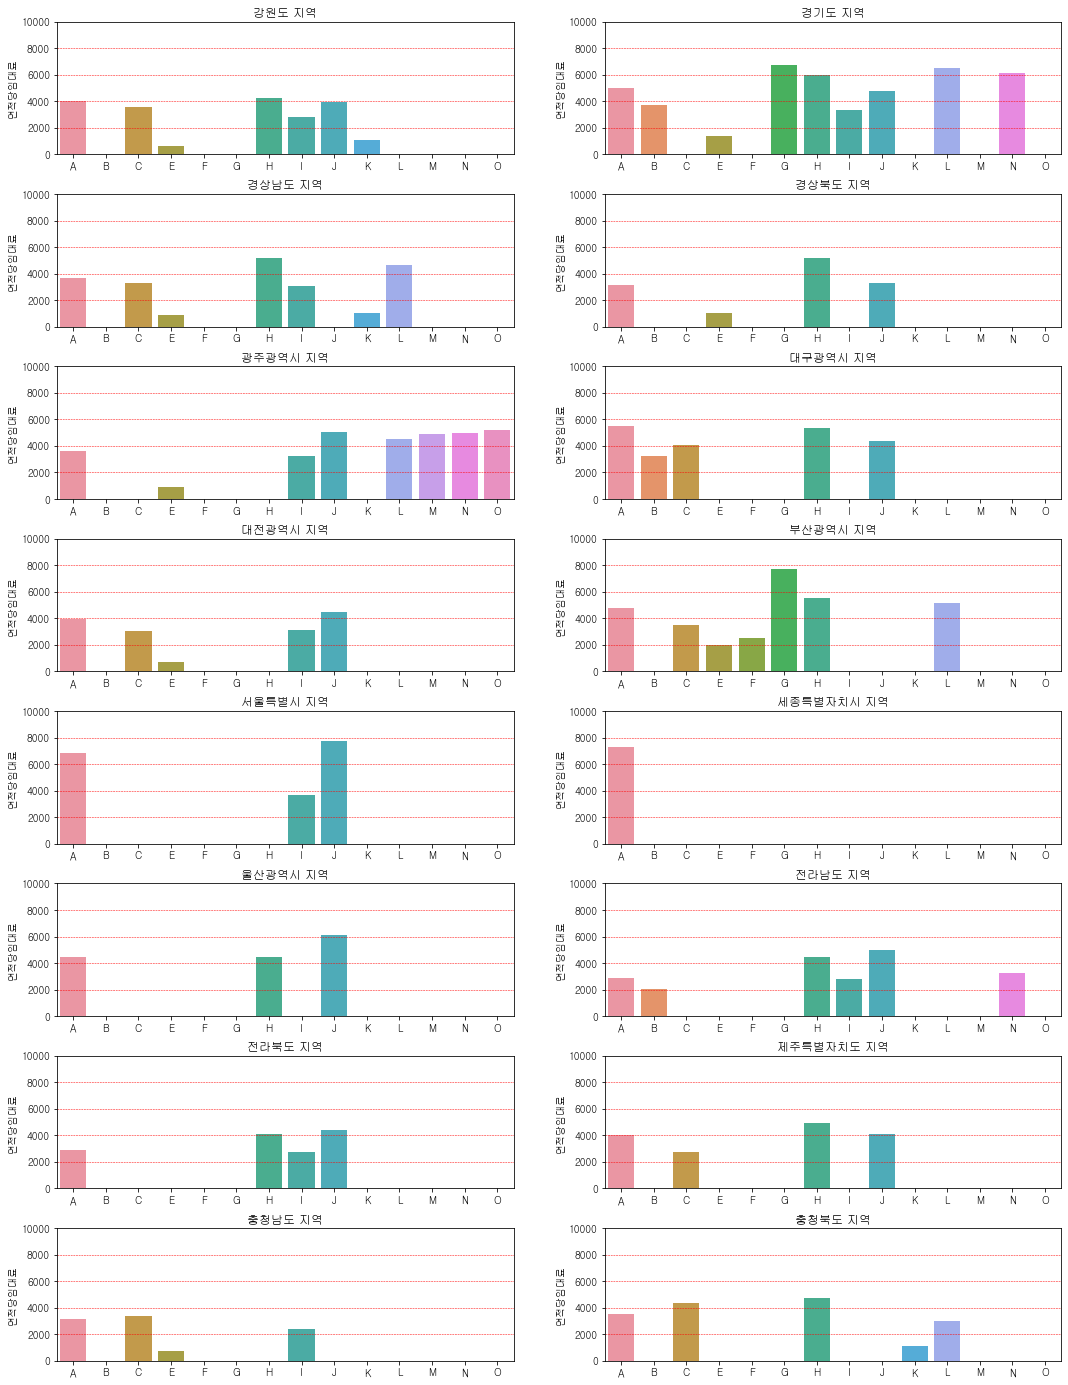

In [174]:
# 지역별로 임대료를 자격유형을 기준, 상대적으로 살펴보기 위함입니다.

fig = plt.figure(figsize=(18, 50))
for i, n in enumerate(list(mean_rent['지역'].unique())):
    plt.subplot(16, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.barplot(data=mean_rent.loc[mean_rent['지역'] == n].sort_values('자격유형'), x='자격유형', y='면적당임대료')
    plt.ylim(top = 10000)
    plt.axhline(y = 2000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 4000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 6000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 8000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.xlabel('')
    plt.title('{} 지역'.format(n))

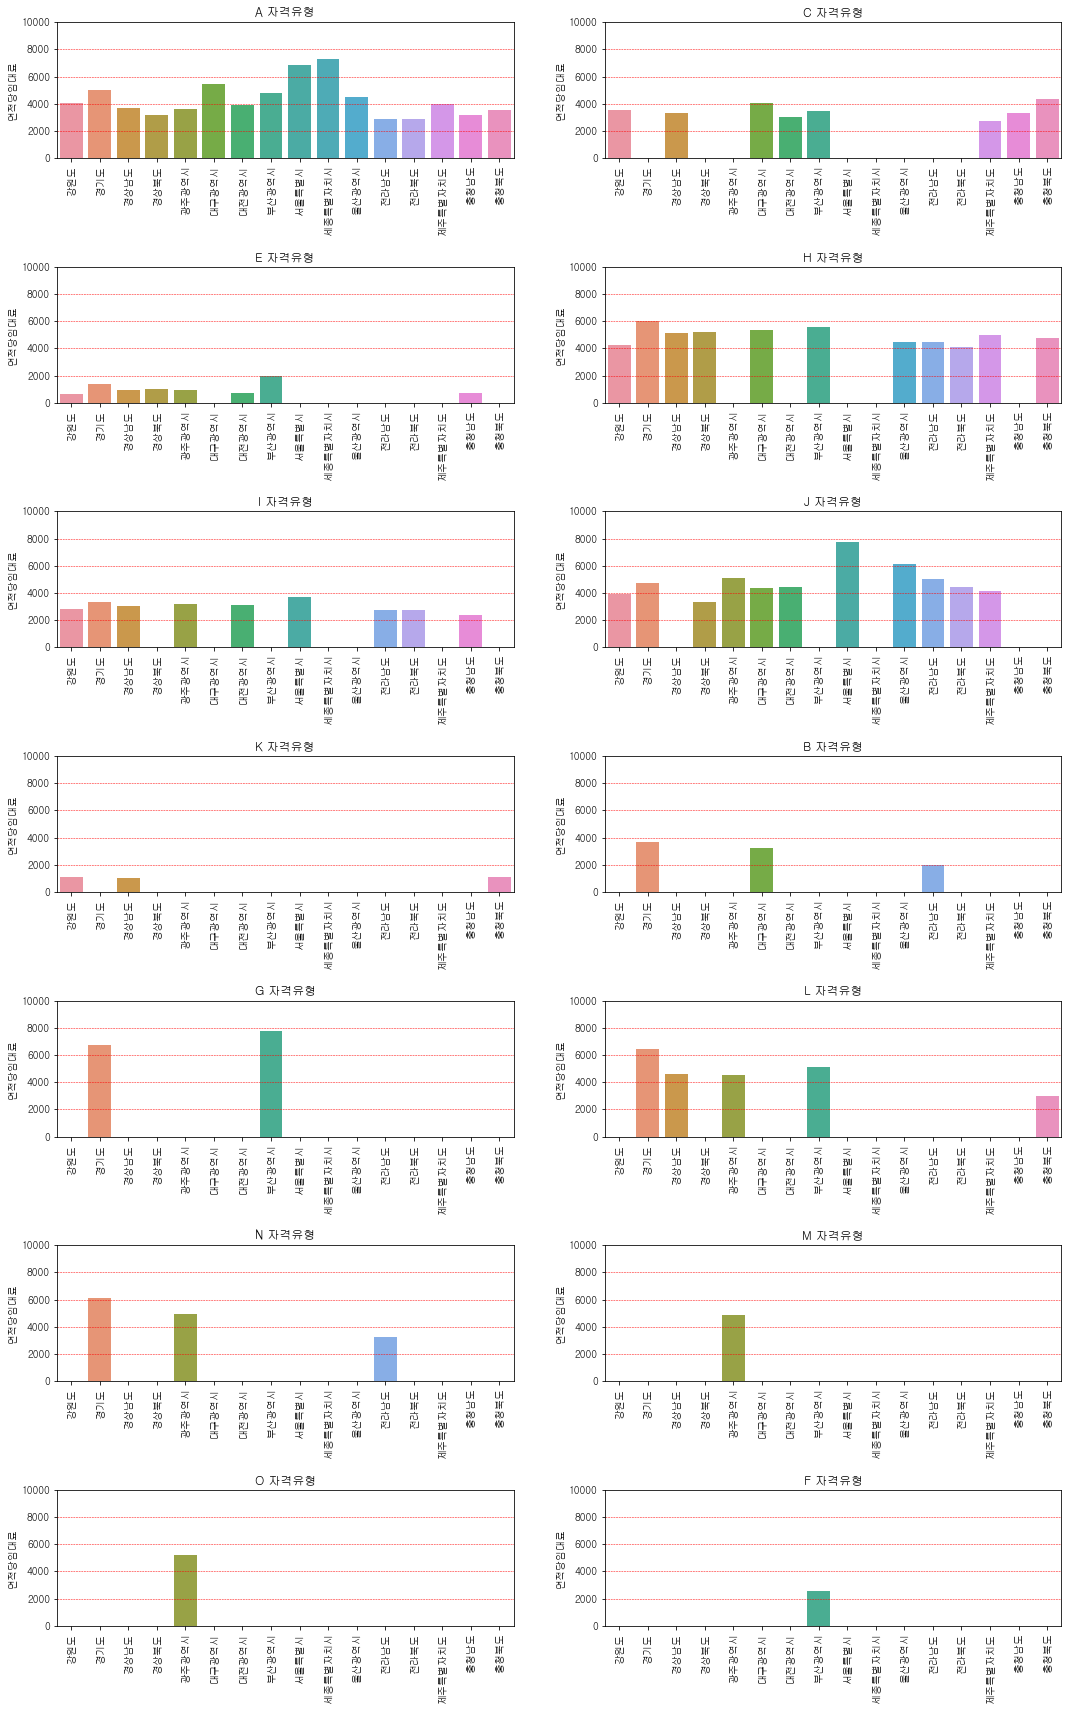

In [175]:
# 지역별로 임대료를 자격유형을 기준, 상대적으로 살펴보기 위함입니다.

fig = plt.figure(figsize=(18, 70))
for i, n in enumerate(list(mean_rent['자격유형'].unique())):
    plt.subplot(16, 2, i+1)
    plt.subplots_adjust(hspace=0.8)
    plots = sns.barplot(data=mean_rent.loc[mean_rent['자격유형'] == n].sort_values('지역'),
                        x='지역', y='면적당임대료')
    plt.ylim(top = 10000)
    plt.axhline(y = 2000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 4000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 6000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 8000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.title('{} 자격유형'.format(n))

- E, K 는 도대체 무엇이길래 모든 지역에서 낮게 형성되는가?
- I도 상대적으로 낮다. 왜 그럴까?

- 확실히 보면, 자격유형이 임대료에 상당히 많은 영향을 미치며, 공급유형이 대체로 자격유형과 연관이 있습니다.
- 동일 단지라고 해서 임대료가 비슷하지가 않습니다.
- 차라리 해당 자격유형의 임대료를 평균으로 산정하고, 국민임대일반지수를 곱해주는 것이 더 나을 수도 있을 것 같습니다.

### 단지내 총 환산보증금액

In [176]:
train_depot = pd.merge(train_danji, train.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index(),
                       how='inner', on='단지코드')

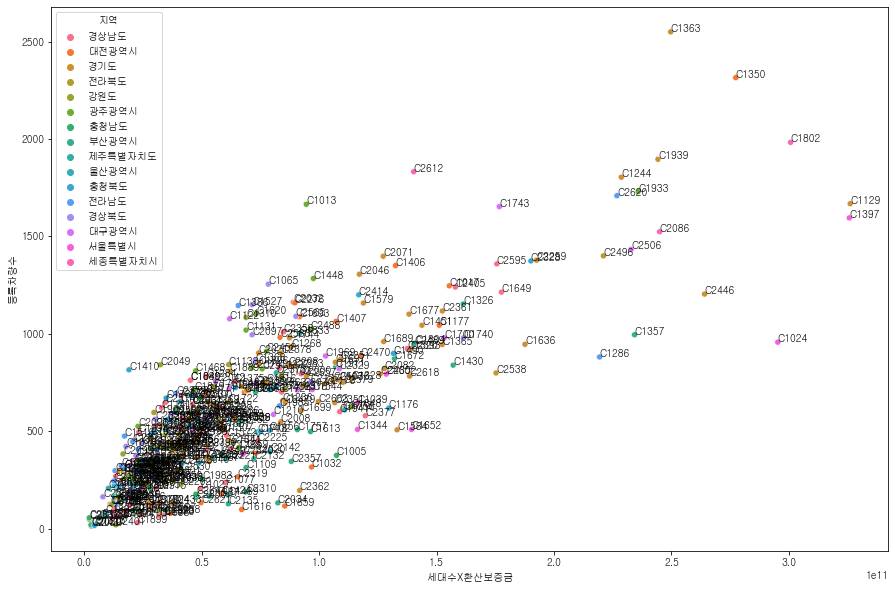

In [177]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_depot, x='세대수X환산보증금', y='등록차량수', hue='지역')
for i, code in enumerate(train_depot['단지코드']):
    plots.annotate(code, (train_depot['세대수X환산보증금'][i], train_depot['등록차량수'][i]))
plt.show()

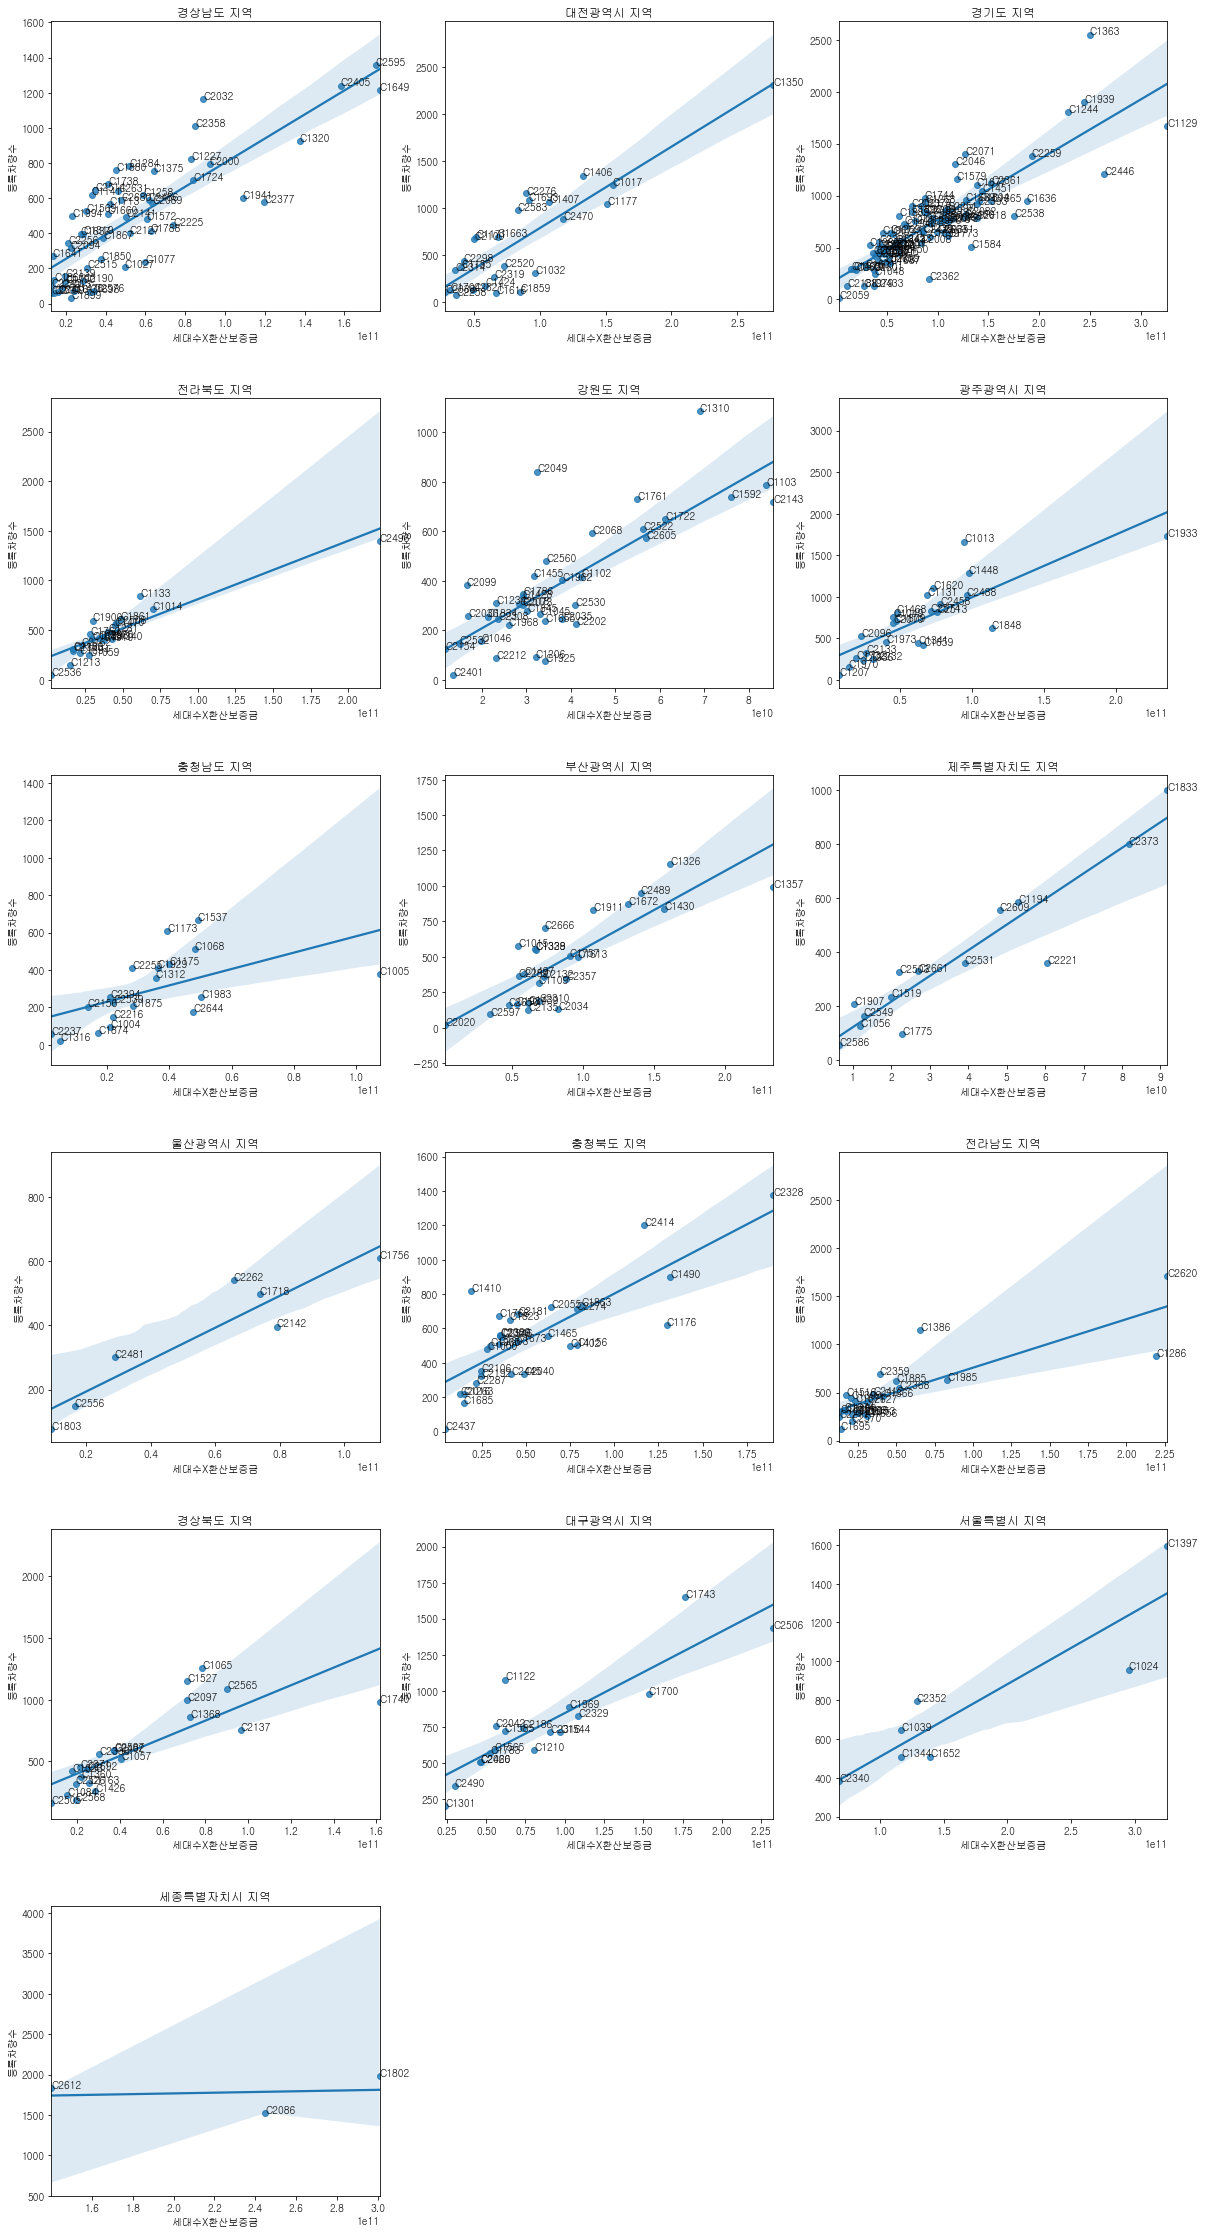

In [178]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_depot['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_depot.loc[train_depot['지역'] == n], x='세대수X환산보증금', y='등록차량수')
    for i, code in enumerate(train_depot.loc[train_depot['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_depot.loc[train_depot['지역'] == n].reset_index(drop=True)['세대수X환산보증금'][i],
                              train_depot.loc[train_depot['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

- 확실히 총세대수, 주차면수, 건축연면적보다는 휘귀선이 조금 더 정확한 것을 알 수 있습니다.

### 대중교통 인프라

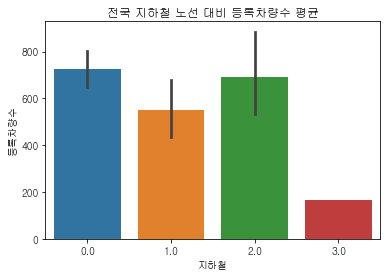

In [179]:
sns.barplot(data=train_danji.loc[train_danji['지역'].isin(['대전광역시', '경기도', '부산광역시', '대구광역시', '서울특별시'])],
            x='지하철', y='등록차량수')
plt.title('전국 지하철 노선 대비 등록차량수 평균')
plt.show()

별다른 정보를 주지 못하고 있다.

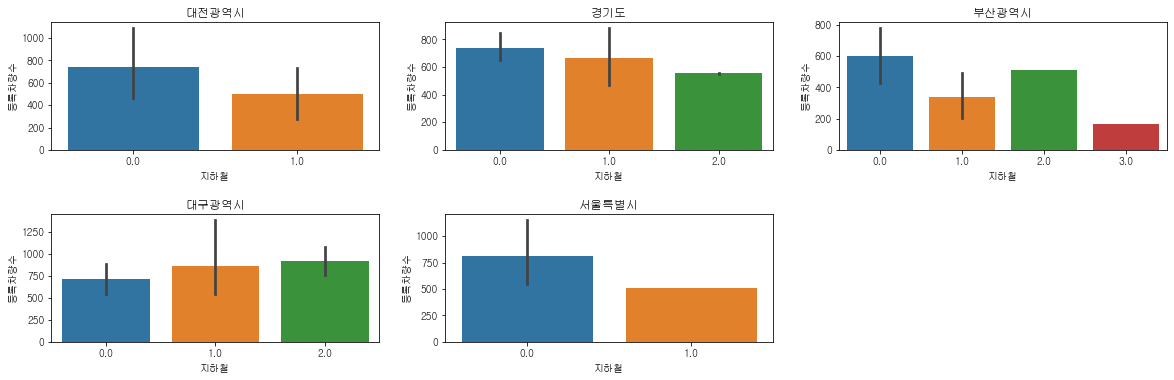

In [180]:
fig = plt.figure(figsize=(20, 20))
for i, n in enumerate(['대전광역시', '경기도', '부산광역시', '대구광역시', '서울특별시']):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.5)
    sns.barplot(data=train_danji.loc[train_danji['지역'] == n], x='지하철', y='등록차량수')
    plt.title(n)

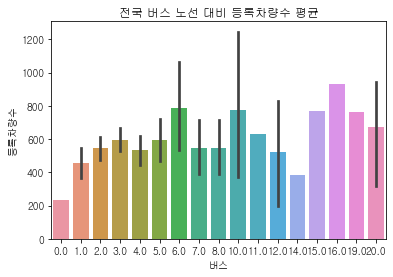

In [181]:
sns.barplot(data=train_danji, x='버스', y='등록차량수')
plt.title('전국 버스 노선 대비 등록차량수 평균')
plt.show()

오히려 버스 정류장이 많을수록 등록차량수가 늘어나는 패턴을 보인다.

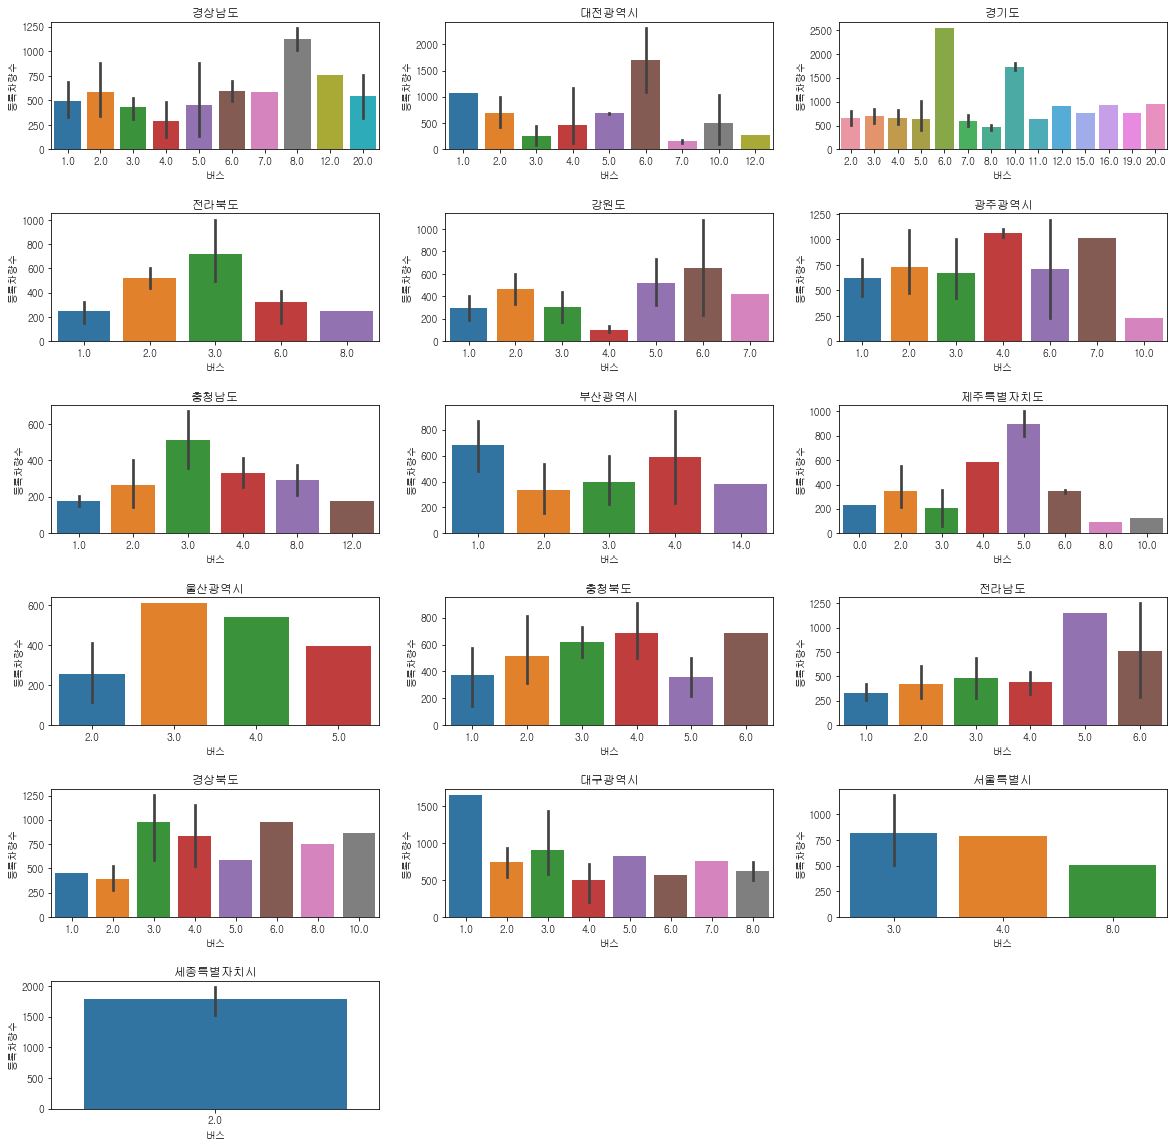

In [182]:
fig = plt.figure(figsize=(20, 20))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.5)
    sns.barplot(data=train_danji.loc[train_danji['지역'] == n], x='버스', y='등록차량수')
    plt.title(n)

지하철 하나가 버스 3개 수준이라면?

In [183]:
train_danji['대중교통'] = (train_danji['지하철'] * 3) + train_danji['버스']

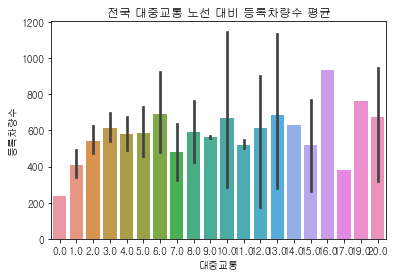

In [184]:
sns.barplot(data=train_danji, x='대중교통', y='등록차량수')
plt.title('전국 대중교통 노선 대비 등록차량수 평균')
plt.show()

# TESTING

### 1. 방의 개수가 차량 보유에 영향을 미치는가?

In [187]:
train.loc[train['전용면적'] < 35, '방개수'] = '1룸'
train.loc[train['전용면적'] >= 35, '방개수'] = '2룸'
train.loc[train['전용면적'] >= 45, '방개수'] = '3룸'
train.loc[train['전용면적'] >= 56, '방개수'] = '4룸'
train.loc[train['전용면적'] >= 77, '방개수'] = '5룸'

In [188]:
test.loc[test['전용면적'] < 35, '방개수'] = '1룸'
test.loc[test['전용면적'] >= 35, '방개수'] = '2룸'
test.loc[test['전용면적'] >= 45, '방개수'] = '3룸'
test.loc[test['전용면적'] >= 56, '방개수'] = '4룸'
test.loc[test['전용면적'] >= 77, '방개수'] = '5룸'

In [189]:
rooms = pd.pivot_table(train.loc[train['임대건물구분'] != '상가'],
                       index='단지코드', columns='방개수', values='전용면적별세대수',
                       aggfunc='sum')

In [190]:
temp = train.groupby(['단지코드'])[['총세대수', '지역', '단지내주차면수', '등록차량수']].max()

In [191]:
rooms_danji = pd.concat([rooms, temp], axis=1)

In [192]:
rooms_danji['1룸비율'] = rooms_danji['1룸'] / rooms_danji['총세대수']
rooms_danji['2룸비율'] = rooms_danji['2룸'] / rooms_danji['총세대수']
rooms_danji['3룸비율'] = rooms_danji['3룸'] / rooms_danji['총세대수']
rooms_danji['4룸비율'] = rooms_danji['4룸'] / rooms_danji['총세대수']
rooms_danji['5룸비율'] = rooms_danji['5룸'] / rooms_danji['총세대수']

rooms_danji['단지내주차면수/총세대수'] = rooms_danji['단지내주차면수'] / rooms_danji['총세대수']
rooms_danji['등록차량수/총세대수'] = rooms_danji['등록차량수'] / rooms_danji['총세대수']
rooms_danji['등록차량수/단지내주차면수'] = rooms_danji['등록차량수'] / rooms_danji['단지내주차면수']

In [193]:
rooms_cols = ['1룸비율', '2룸비율', '3룸비율', '4룸비율', '5룸비율']

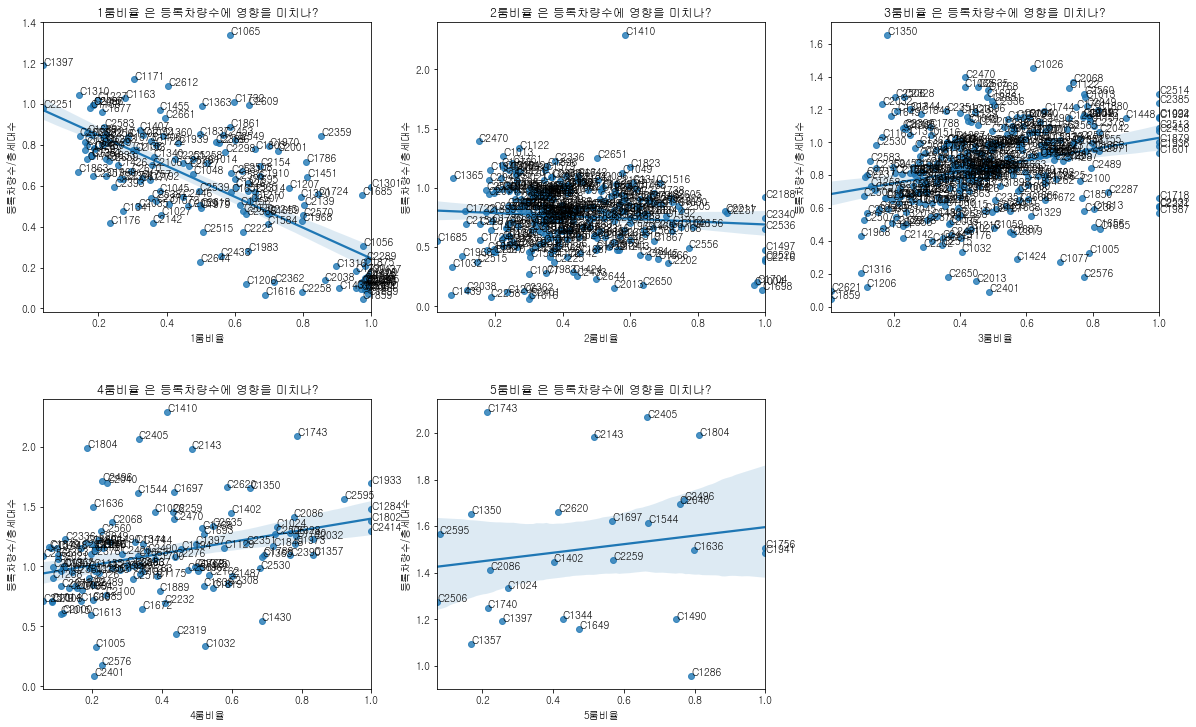

In [194]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(rooms_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=rooms_danji, x=n, y='등록차량수/총세대수')
    for i, code in enumerate(rooms_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (rooms_danji.reset_index(drop=False)[n][i],
                              rooms_danji.reset_index(drop=False)['등록차량수/총세대수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

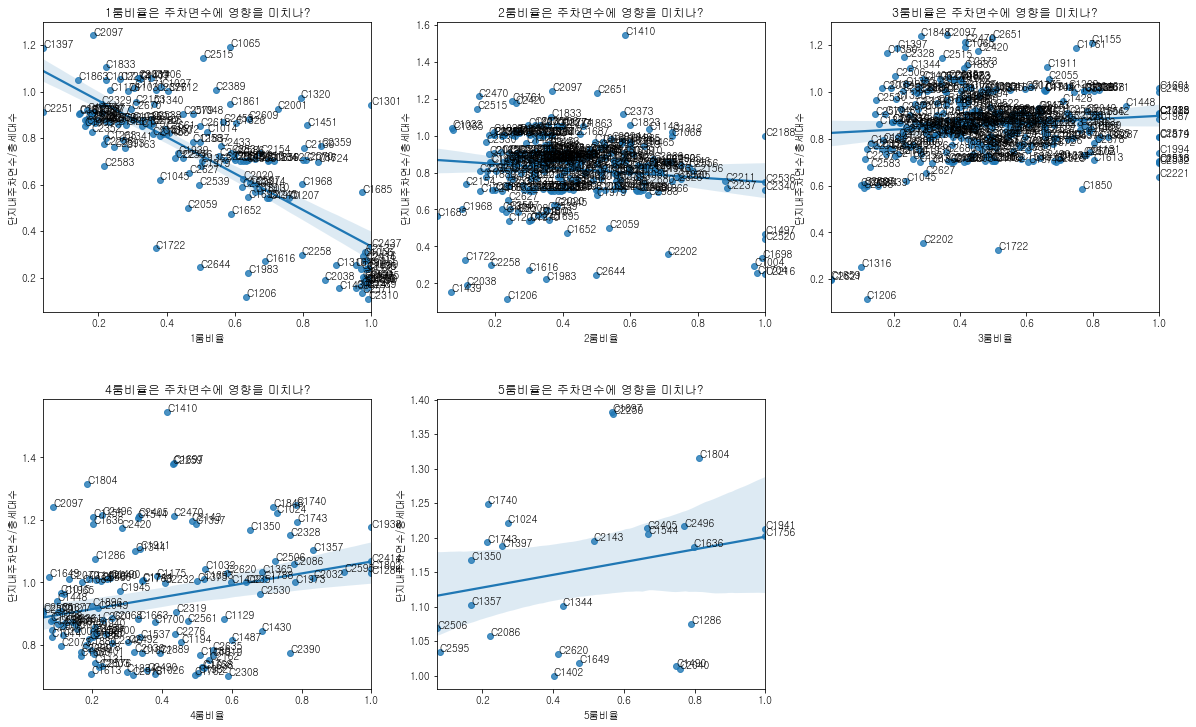

In [195]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(rooms_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=rooms_danji, x=n, y='단지내주차면수/총세대수')
    for i, code in enumerate(rooms_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (rooms_danji.reset_index(drop=False)[n][i],
                              rooms_danji.reset_index(drop=False)['단지내주차면수/총세대수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

### 2. 크기 분류가 차량 보유에 영향을 미치는가?

In [196]:
# 80 ~ 은 대형
# 40 ~ 80 은 중형
# ~ 40 은 소형

train.loc[train['전용면적'] < 40, '전용면적구분'] = '소형'
train.loc[train['전용면적'] >= 40, '전용면적구분'] = '중형'
train.loc[train['전용면적'] >= 80, '전용면적구분'] = '대형'

test.loc[test['전용면적'] < 40, '전용면적구분'] = '소형'
test.loc[test['전용면적'] >= 40, '전용면적구분'] = '중형'
test.loc[test['전용면적'] >= 80, '전용면적구분'] = '대형'

In [197]:
size = pd.pivot_table(train.loc[train['임대건물구분'] != '상가'],
                       index='단지코드', columns='전용면적구분', values='전용면적별세대수',
                       aggfunc='sum')

In [198]:
temp = train.groupby(['단지코드'])[['총세대수', '지역', '단지내주차면수', '등록차량수']].max()

In [199]:
size_danji = pd.concat([size, temp], axis=1)

In [200]:
size_danji['소형비율'] = size_danji['소형'] / size_danji['총세대수']
size_danji['중형비율'] = size_danji['중형'] / size_danji['총세대수']
size_danji['대형비율'] = size_danji['대형'] / size_danji['총세대수']

size_danji['단지내주차면수/총세대수'] = size_danji['단지내주차면수'] / size_danji['총세대수']
size_danji['등록차량수/총세대수'] = size_danji['등록차량수'] / size_danji['총세대수']
size_danji['등록차량수/단지내주차면수'] = size_danji['등록차량수'] / size_danji['단지내주차면수']

In [201]:
size_cols = ['소형비율', '중형비율', '대형비율']

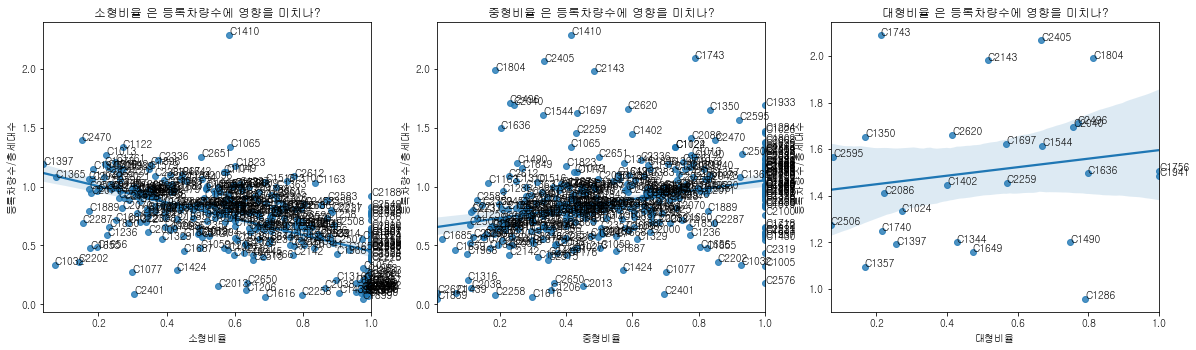

In [202]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(size_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=size_danji, x=n, y='등록차량수/총세대수')
    for i, code in enumerate(size_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (size_danji.reset_index(drop=False)[n][i],
                              size_danji.reset_index(drop=False)['등록차량수/총세대수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

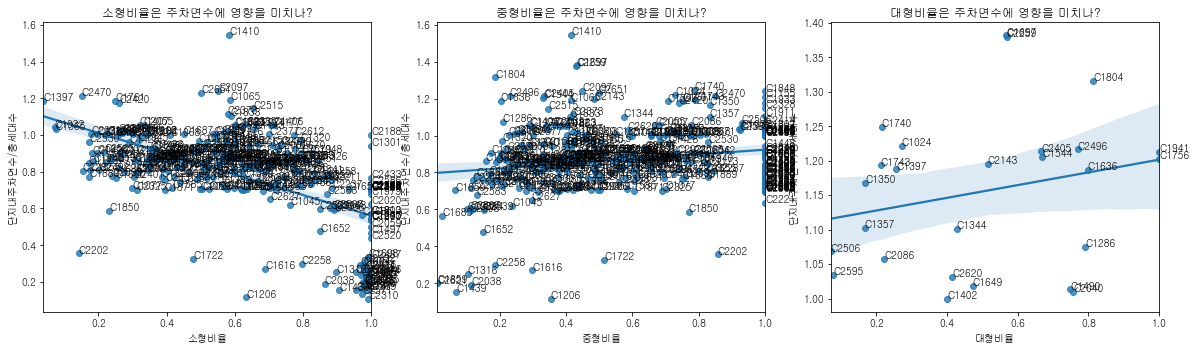

In [203]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(size_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=size_danji, x=n, y='단지내주차면수/총세대수')
    for i, code in enumerate(size_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (size_danji.reset_index(drop=False)[n][i],
                              size_danji.reset_index(drop=False)['단지내주차면수/총세대수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

### 3. 땅값이 중요할까?

단지코드별 평균 면적당환산보증금이 그나마 지가에 가깝지 않을까 합니다

In [204]:
train_land = pd.merge(train_danji, train.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index(),
                      how='inner', on='단지코드')

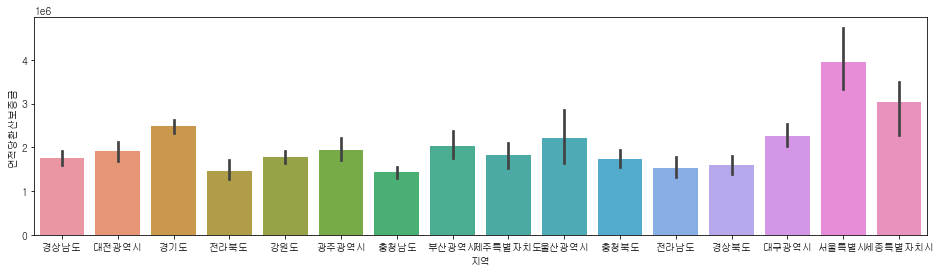

In [205]:
plt.figure(figsize=(16, 4))
sns.barplot(data=train_land, x='지역', y='면적당환산보증금')
plt.show()

In [206]:
train_land['세대당등록차량수'] = train_land['등록차량수'] / train_land['총세대수']

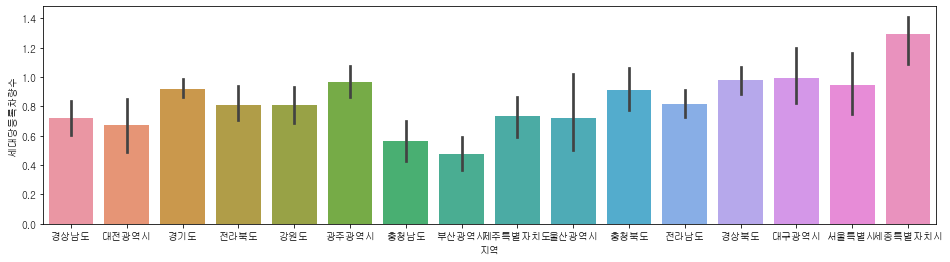

In [207]:
plt.figure(figsize=(16, 4))
sns.barplot(data=train_land, x='지역', y='세대당등록차량수')
plt.show()

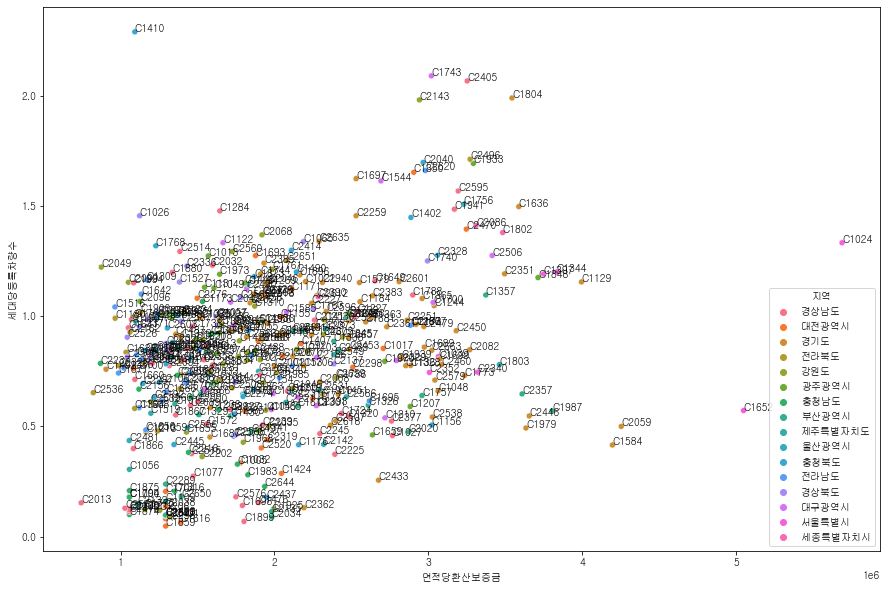

In [208]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_land, x='면적당환산보증금', y='세대당등록차량수', hue='지역')
for i, code in enumerate(train_land['단지코드']):
    plots.annotate(code, (train_land['면적당환산보증금'][i], train_land['세대당등록차량수'][i]))
#plt.xlim(right=4000)
plt.show()

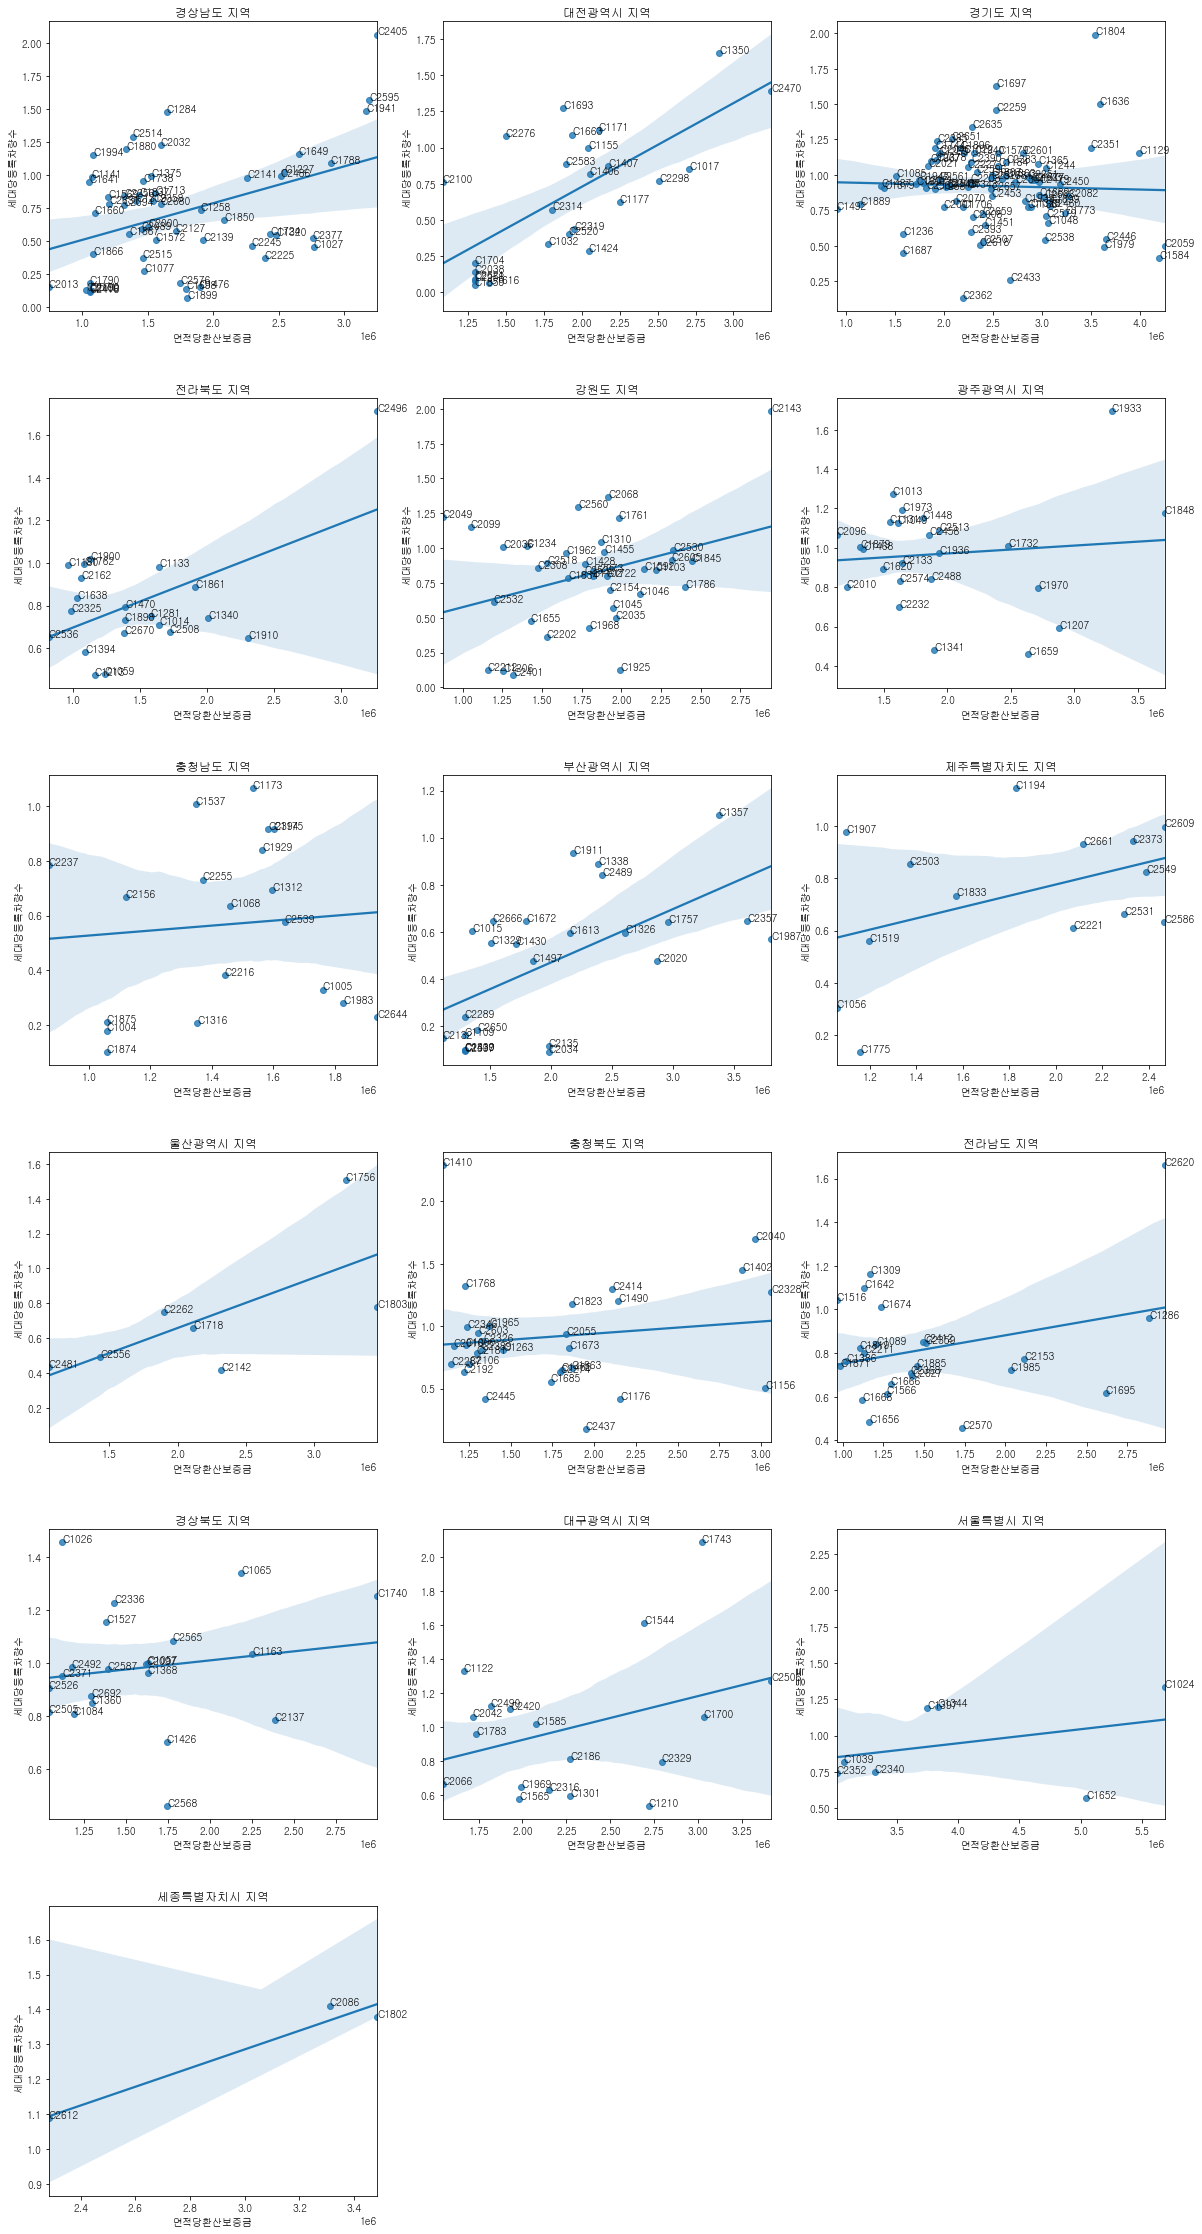

In [209]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_land['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_land.loc[train_land['지역'] == n], x='면적당환산보증금', y='세대당등록차량수')
    for i, code in enumerate(train_land.loc[train_land['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_land.loc[train_land['지역'] == n].reset_index(drop=True)['면적당환산보증금'][i],
                              train_land.loc[train_land['지역'] == n].reset_index(drop=True)['세대당등록차량수'][i]))
    plt.title('{} 지역'.format(n))

### 4. 임대기간 X 임대료

In [210]:
train['공급유형'].unique()

array(['국민임대', '공공임대(50년)', '영구임대', '공공임대(10년)', '공공임대(분납)', '장기전세',
       '공공분양', '행복주택', '공공임대(5년)'], dtype=object)

- 국민임대: 최장 30년
- 공공임대: 임대 후 분양, 50년, 10년, 5년
- 공공분납: 임대 후 분양, 10년, 입주 시 보증금을 많이 내고 임대료가 낮음
- 영구임대: 국민임대의 장기 버전, 50년
- 장기전세: 전세로 장기 거주
- 행복주택: 30년, 청년은 6년


- 연도가 정해져 있지 않으면 10년으로 산정하면 얼추 맞다.

In [211]:
train.loc[~train['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    train.loc[~train['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + train.loc[~train['공급유형'].isin(['공공임대(5년)']), '임대료'] * 120
)

In [212]:
train.loc[train['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    train.loc[train['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + train.loc[train['공급유형'].isin(['공공임대(5년)']), '임대료'] * 60
)

In [213]:
test.loc[~test['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    test.loc[~test['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + test.loc[~test['공급유형'].isin(['공공임대(5년)']), '임대료'] * 120
)

In [214]:
test.loc[test['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    test.loc[test['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + test.loc[test['공급유형'].isin(['공공임대(5년)']), '임대료'] * 60
)

In [215]:
train['만기임대료X세대수'] = train['만기임대료'] * train['전용면적별세대수']
test['만기임대료X세대수'] = test['만기임대료'] * test['전용면적별세대수']

In [216]:
train_land = pd.merge(train_danji, train.groupby(['단지코드'])['만기임대료X세대수'].sum().reset_index(),
                      how='inner', on='단지코드')

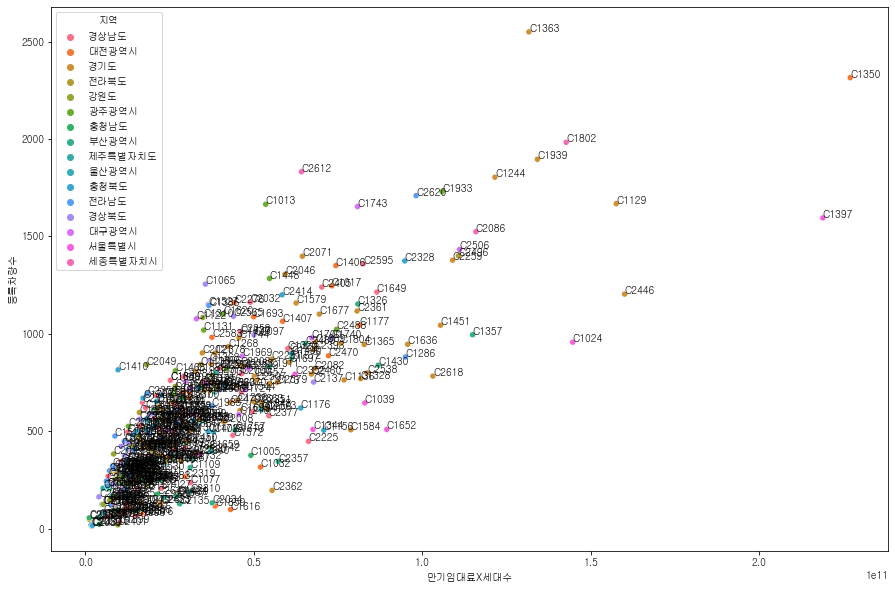

In [217]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_land, x='만기임대료X세대수', y='등록차량수', hue='지역')
for i, code in enumerate(train_land['단지코드']):
    plots.annotate(code, (train_land['만기임대료X세대수'][i], train_land['등록차량수'][i]))
#plt.xlim(right=4000)
plt.show()

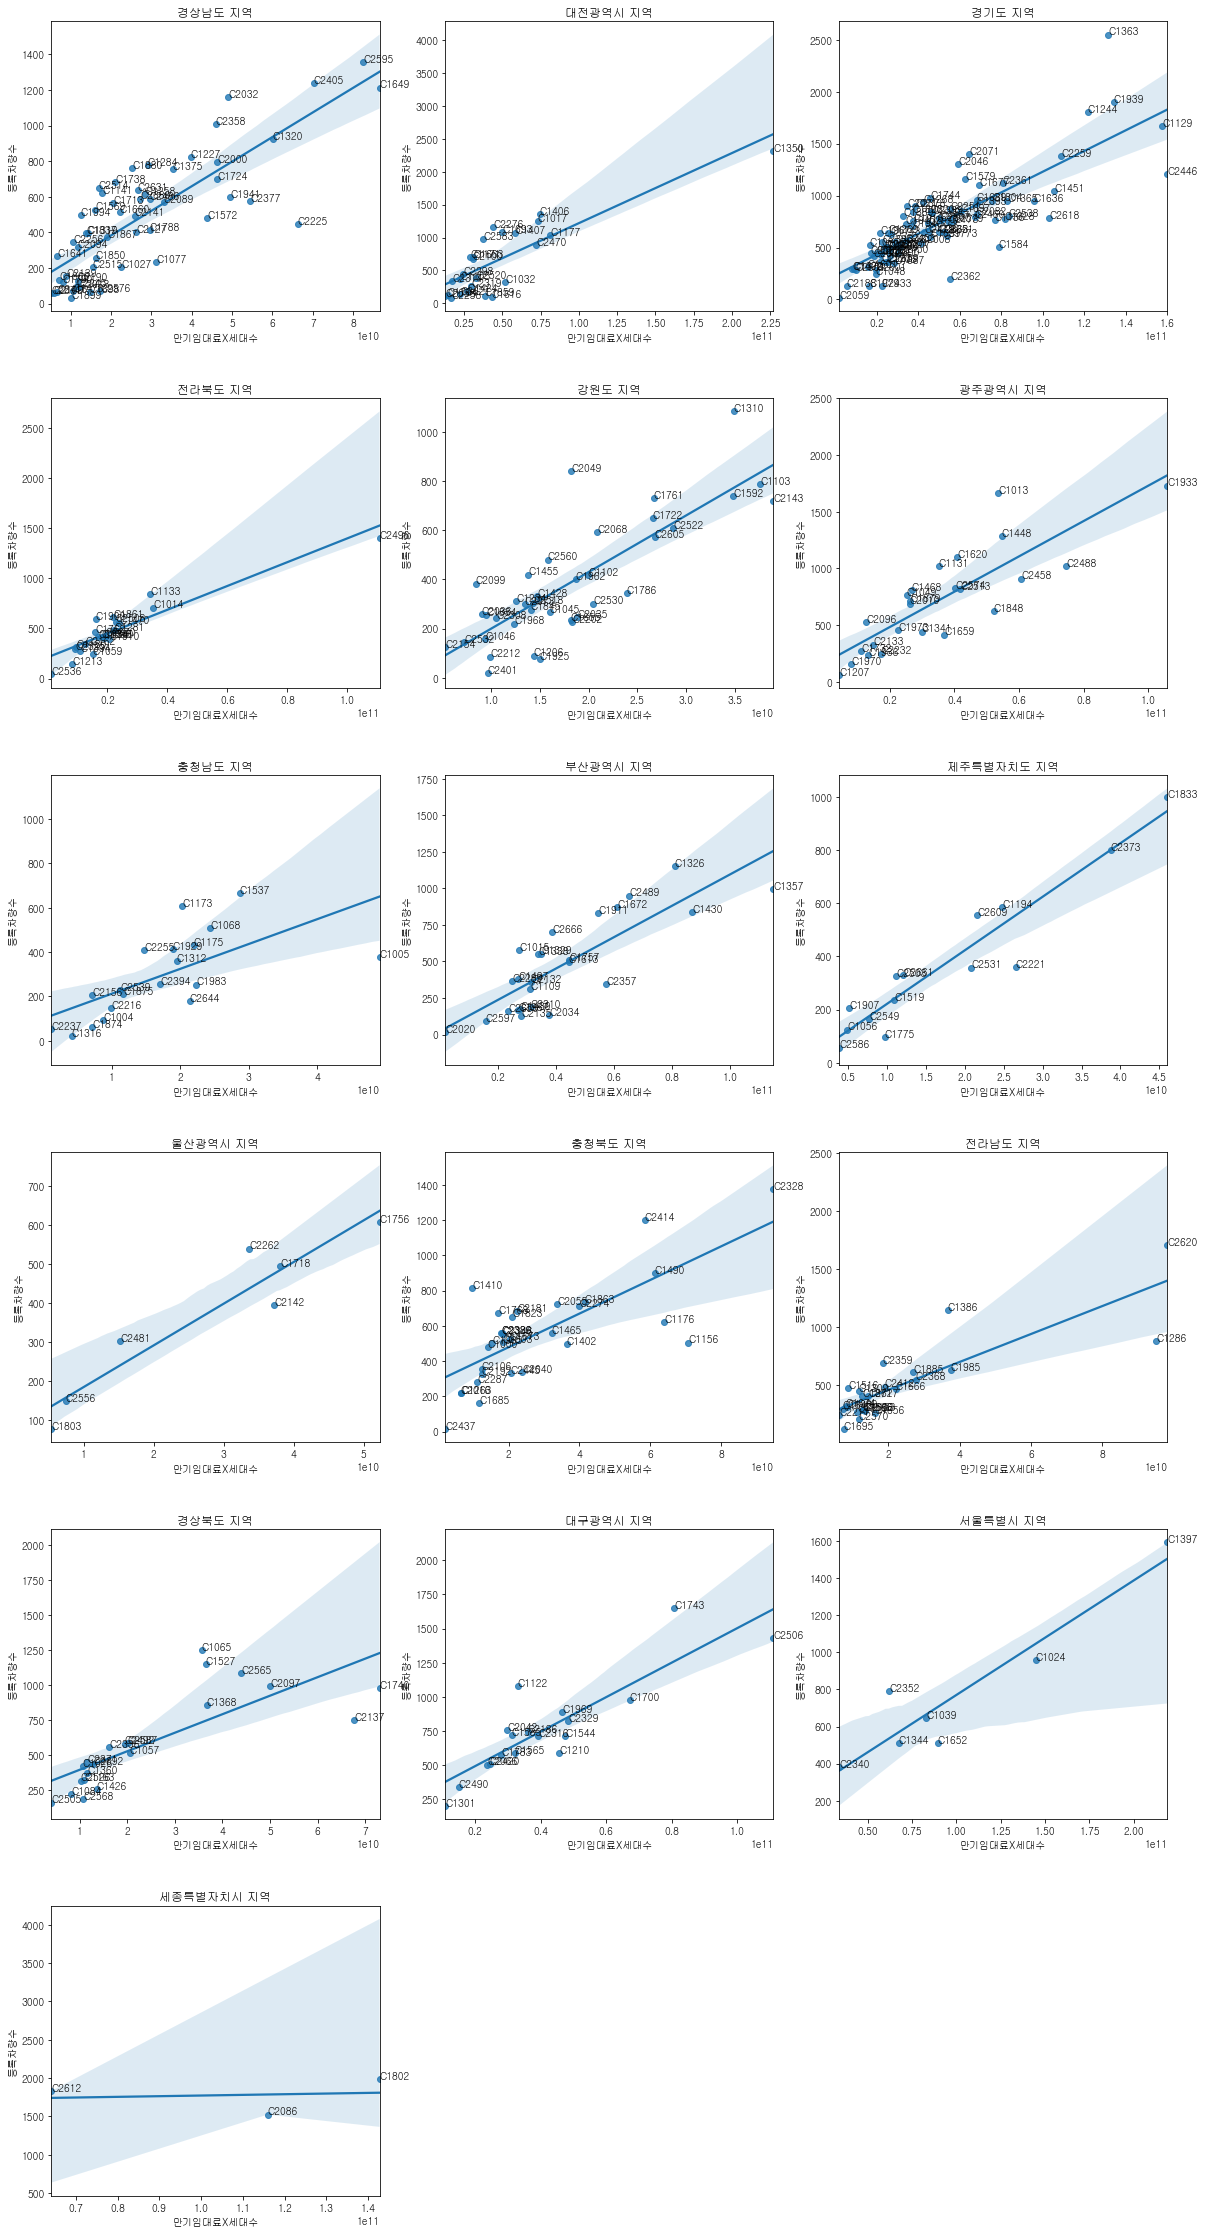

In [218]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_land['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_land.loc[train_land['지역'] == n], x='만기임대료X세대수', y='등록차량수')
    for i, code in enumerate(train_land.loc[train_land['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_land.loc[train_land['지역'] == n].reset_index(drop=True)['만기임대료X세대수'][i],
                              train_land.loc[train_land['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

### 5. 단지내주차면수를 총세대수로 나눈 값이면?

In [219]:
train['총세대수/주차면수'] = train['총세대수'] / train['단지내주차면수']
test['총세대수/주차면수'] = test['총세대수'] / test['단지내주차면수']

In [220]:
train_danji['총세대수/주차면수'] = train_danji['총세대수'] / train_danji['단지내주차면수']
test_danji['총세대수/주차면수'] = test_danji['총세대수'] / test_danji['단지내주차면수']

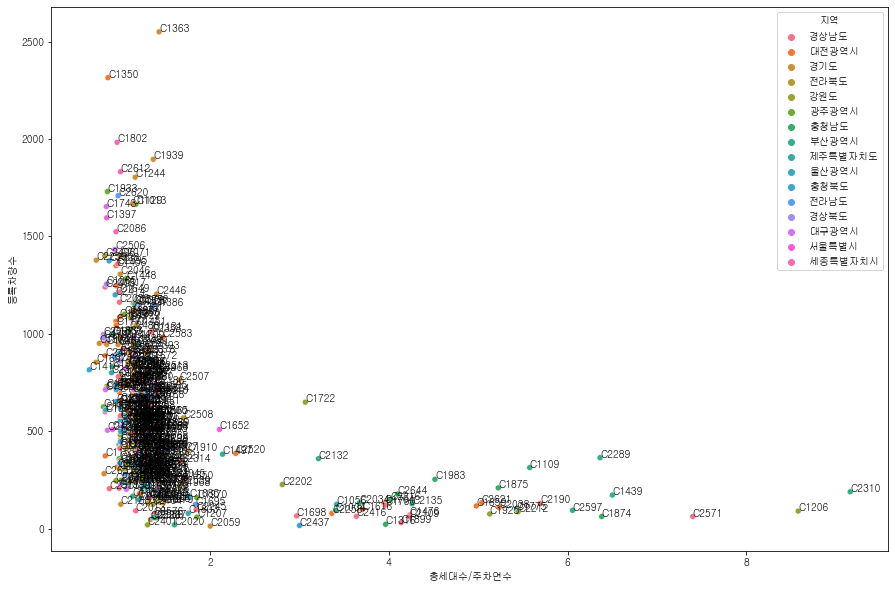

In [221]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='총세대수/주차면수', y='등록차량수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['총세대수/주차면수'][i], train_danji['등록차량수'][i]))
#plt.xlim(right=4000)
plt.show()

보통은 저 흑기둥 분포가 나와야 맞는데, 우측에 뿜어져 나오는 이상한 애들은 도대체 뭘까?

### 6. 지역, 단지 별로 총세대수를 세대수로 넣어볼까?

In [222]:
ag = age_gender.set_index('지역')

In [223]:
# 남성비
ag.loc[:, '남성비'] = ag.loc[:, (ag.columns.str.contains('여자'))].sum(axis=1)
# 여성비
ag.loc[:, '여성비'] = ag.loc[:, (ag.columns.str.contains('남자'))].sum(axis=1)
# 성인(20대~60대)비중합
ag.loc[:, '청년비중'] = ag.loc[:, (ag.columns.str.contains('20대')) | (ag.columns.str.contains('30대'))
                           | (ag.columns.str.contains('40대')) | (ag.columns.str.contains('50대'))
                           | (ag.columns.str.contains('60대'))].sum(axis=1)
# 미성년자(10대이하)비중
ag.loc[:, '미성년자비중'] = ag.loc[:, (ag.columns.str.contains('10대'))].sum(axis=1)
# 노인비중(70대~)비중합
ag.loc[:, '노년비중'] = ag.loc[:, (ag.columns.str.contains('70대')) | (ag.columns.str.contains('80대'))
                           | (ag.columns.str.contains('90대')) | (ag.columns.str.contains('100대'))].sum(axis=1)
# # 성인여성비중
# ag.loc[:, '청년여성비중'] = ag.loc[:, ['20대(여자)', '30대(여자)', '40대(여자)', '50대(여자)', '60대(여자)']].sum(axis=1)
# # 성인남성비중
# ag.loc[:, '청년남성비중'] = ag.loc[:, ['20대(남자)', '30대(남자)', '40대(남자)', '50대(남자)', '60대(남자)']].sum(axis=1)

In [224]:
ag_temp = ag.reset_index()[['지역', '남성비', '여성비', '청년비중', '미성년자비중', '노년비중']]

In [225]:
train = pd.merge(train, ag_temp, how='left', on='지역')
test = pd.merge(test, ag_temp, how='left', on='지역')

In [226]:
train['남성세대수'] = train['전용면적별세대수'] * train['남성비']
train['여성세대수'] = train['전용면적별세대수'] * train['여성비']
train['청년세대수'] = train['전용면적별세대수'] * train['청년비중']
train['미성년세대수'] = train['전용면적별세대수'] * train['미성년자비중']
train['노년세대수'] = train['전용면적별세대수'] * train['노년비중']

test['남성세대수'] = test['전용면적별세대수'] * test['남성비']
test['여성세대수'] = test['전용면적별세대수'] * test['여성비']
test['청년세대수'] = test['전용면적별세대수'] * test['청년비중']
test['미성년세대수'] = test['전용면적별세대수'] * test['미성년자비중']
test['노년세대수'] = test['전용면적별세대수'] * test['노년비중']

In [227]:
train.drop(['남성비', '여성비', '청년비중', '미성년자비중', '노년비중'], axis=1, inplace=True)
test.drop(['남성비', '여성비', '청년비중', '미성년자비중', '노년비중'], axis=1, inplace=True)

In [228]:
train_ag = pd.merge(train_danji,
         train.groupby(['단지코드'])[['남성세대수', '여성세대수', '청년세대수', '미성년세대수', '노년세대수']].sum().reset_index(),
         how='inner', on='단지코드')

In [229]:
ag_cols = ['남성세대수', '여성세대수', '청년세대수', '미성년세대수', '노년세대수']

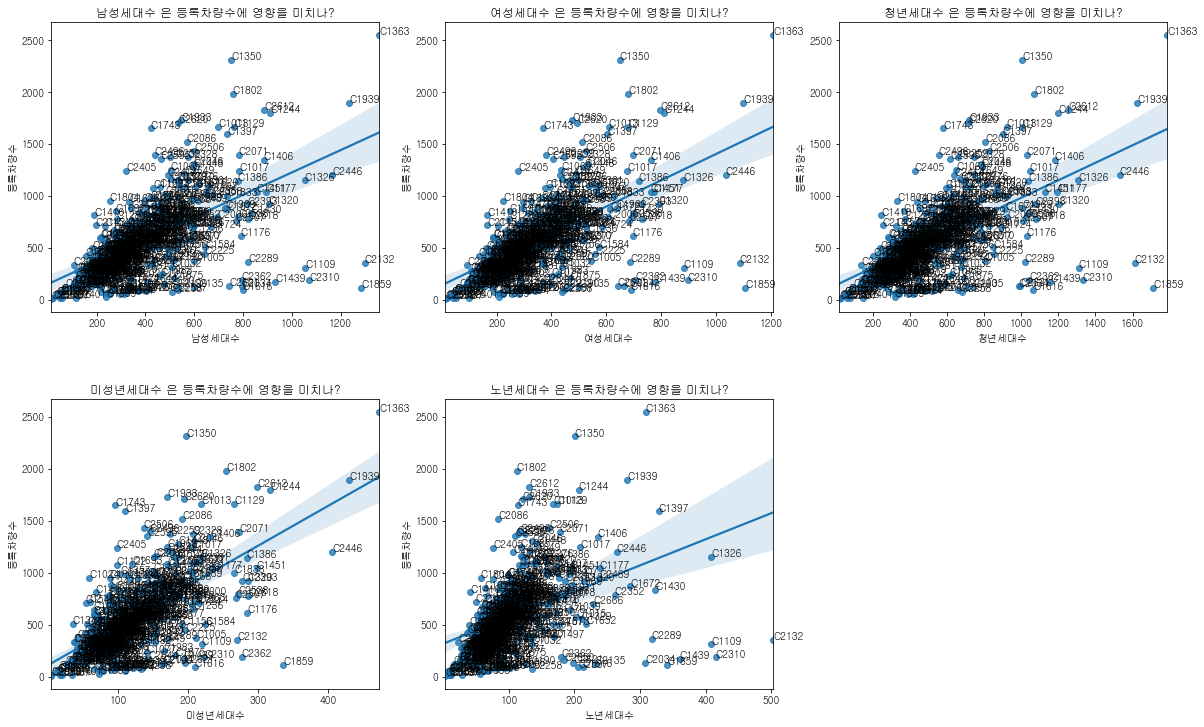

In [230]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(ag_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_ag, x=n, y='등록차량수')
    for i, code in enumerate(train_ag.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (train_ag.reset_index(drop=False)[n][i],
                              train_ag.reset_index(drop=False)['등록차량수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

# INSIGHT